In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import time
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yaml

from gan.wgan_torch import Critic, Generator, initialise_weights, gradient_penalty
from functions.data_cleaning import DataClean as dc
from functions.utilities import *
from functions.metrics import *
from functions.figure_plotting import FigurePlot as fp

In [2]:
sns.set_theme()
sns.set_style("ticks")

#Avant Garde palette
CB91_Brown = "#7d5a1b"
CB91_Brown_Gray = "#816b51"
CB91_Green = "#294013"
CB91_Light_Green = "#d8ffc4"
CB91_Red = "#84290d"

# Out of palette
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Yellow = "#dfc077"

Green_Grad = ["#d8ffc4", "#bbdfa7", "#9ebf89", "#81a06c", "#63804e", "#466031", 
              "#294013", "#24380f", "#1e310b", "#192908", "#132204", "#0e1a00"]

Red_Grad = ["#fff1e3", "#efc6b0", "#df9b7d", "#cf6f4a", "#bf4417", "#ab3b14",
            "#983210", "#84290d", "#70200a", "#5c1707", "#490e03", "#350500"]

Brown_Grad = ["#fffac3", "#efda9d", "#dfc077", "#cfa550",  "#bf8b2a", "#a97a24", 
              "#93681e", "#7d5718", "#684512", "#52340c", "#3c2206", "#261100"]

color_list = [CB91_Brown, CB91_Green, CB91_Light_Green, CB91_Red,
              CB91_Purple, CB91_Violet,  CB91_Yellow, CB91_Brown_Gray]

#A list of hex colours running between blue and purple
CB91_Grad_BP = ['#2cbdfe', '#2fb9fc', '#33b4fa', '#36b0f8',
                '#3aacf6', '#3da8f4', '#41a3f2', '#449ff0',
                '#489bee', '#4b97ec', '#4f92ea', '#528ee8',
                '#568ae6', '#5986e4', '#5c81e2', '#607de0',
                '#6379de', '#6775dc', '#6a70da', '#6e6cd8',
                '#7168d7', '#7564d5', '#785fd3', '#7c5bd1',
                '#7f57cf', '#8353cd', '#864ecb', '#894ac9',
                '#8d46c7', '#9042c5', '#943dc3', '#9739c1',
                '#9b35bf', '#9e31bd', '#a22cbb', '#a528b9',
                '#a924b7', '#ac20b5', '#b01bb3', '#b317b1']

sns.set(font="Verdana",
        rc={
        "axes.axisbelow": False,
        "axes.edgecolor": "lightgrey",
        "axes.facecolor": "None",
        "axes.grid": False,
        "axes.labelcolor": "dimgrey",
        "axes.spines.right": False,
        "axes.spines.top": False,
        "figure.facecolor": "white",
        "lines.solid_capstyle": "round",
        "patch.edgecolor": "w",
        "patch.force_edgecolor": True,
        "text.color": "dimgrey",
        "xtick.bottom": False,
        "xtick.color": "dimgrey",
        "xtick.direction": "out",
        "xtick.top": False,
        "ytick.color": "dimgrey",
        "ytick.direction": "out",
        "ytick.left": False,
        "ytick.right": False})
 
custom_colors = color_list
sns.set_palette(sns.color_palette(color_list, 8))

sns.set_context("notebook", rc={"font.size":16,
                                "axes.titlesize":20,
                                "axes.labelsize":18})

# WGAN-GP with Pytorch
paper: https://arxiv.org/abs/1704.00028v3 (Arjovsky et al.)
code:  https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/wgan_gp/wgan_gp.py

General explanation: https://towardsdatascience.com/demystified-wasserstein-gan-with-gradient-penalty-ba5e9b905ead

In [3]:
torch.manual_seed(42)

In [4]:
reload = True  # Load and use pretrained model if True
select_model = 2  # latent: 0=15 1=30 2=50 3=100
save_figure = False
save_curve = False

In [5]:
model_configuration_file = "configurations/torch_gan.yaml"
preprocessing_configuration_file = "configurations/categorical_preprocessing_configuration.yaml"
plotting_configuration_file = "configurations/print.yaml"
data_filename = "data/original_preprocessed.csv"
# data_filename = "data/FI_2013p_EUSILC.csv"
draw = fp(plotting_configuration_file)

In [6]:
with open(model_configuration_file, 'r') as file:
    cfg = yaml.safe_load(file)
gan_cfg = cfg["model"]
model = cfg["globals"]["name"]
model_name = cfg["globals"]["model_name"][select_model]
model_type = cfg["globals"]["model_type"]

In [7]:
number_epochs = int(gan_cfg["epochs"][select_model])
learning_rate = float(gan_cfg["learning_rate"][0])
batch_size = gan_cfg["batch_size"]
beta_1 = float(gan_cfg["beta1"])
beta_2 = float(gan_cfg["beta2"])
optimiser_name = gan_cfg["optimiser_name"]
critic_iterations = int(gan_cfg["critic_iterations"])
lambda_gp = float(gan_cfg["lambda_gp"])

In [8]:
begin = time.time()
data = dc(datafile=data_filename,
          prepared=True,
          configuration_file=preprocessing_configuration_file,
          )
duration = time.time() - begin
print(duration)

Using provided preprocessed file data/original_preprocessed.csv
0.12390351295471191


In [9]:
df = data.get_data()
feature_dimension = df.shape[1]
df_o = data.get_data()
torch_data_o = torch.tensor(df_o.values, dtype=torch.float32)

In [10]:
if reload:
    model_collection = []
    for lat in gan_cfg["latent_dimensions"]:
        print(lat)
        print(type(lat))
        gen = Generator(feature_dimension, lat)
        cri = Critic(feature_dimension, output_dim=1)
        opt_cri = optim.Adam(cri.parameters(), lr=learning_rate, betas=(beta_1, beta_2))  # GAN + WGAN-GP
        opt_gen = optim.Adam(gen.parameters(), lr=learning_rate, betas=(beta_1, beta_2))  # GAN + WGAN-GP
        gen.load_state_dict(torch.load(gan_cfg["generator_dict_file_" + str(lat)]))
        opt_gen.load_state_dict(torch.load(gan_cfg["opt_gen_dict_file_" + str(lat)]))
        cri.load_state_dict(torch.load(gan_cfg["critic_dict_file_" + str(lat)]))
        opt_cri.load_state_dict(torch.load(gan_cfg["opt_critic_dict_file_" + str(lat)]))
        model_collection.append((lat, gen, cri))

15
<class 'int'>
30
<class 'int'>
50
<class 'int'>
100
<class 'int'>


In [11]:
if reload:
    synthetic_collection = []
    for lat, gen, _ in model_collection:
        torch_s = get_synthetic(gen, df.shape[0], lat)
        synthetic_collection.append(data.get_synthetic(torch_s, columns=df.columns))

Do detect 65 difference!!!
Old data shape (19291, 165)
New dataframe shape (19291, 65)
Returned dataframe has shape (19291, 230)
Do detect 28 difference!!!
Old data shape (19291, 202)
New dataframe shape (19291, 28)
Returned dataframe has shape (19291, 230)
Do detect 14 difference!!!
Old data shape (19291, 216)
New dataframe shape (19291, 14)
Returned dataframe has shape (19291, 230)
Do detect 9 difference!!!
Old data shape (19291, 221)
New dataframe shape (19291, 9)
Returned dataframe has shape (19291, 230)


In [12]:
# Select the data to use (df_o --> full, df_o_red --> one category removed)
use_data = df_o
torch_data = torch_data_o

In [13]:
use_data.shape

(19291, 230)

In [14]:
torch_data.shape

torch.Size([19291, 230])

In [15]:
latent_dimension = gan_cfg["latent_dimensions"][select_model] # [0]=15 [1]=30 [2]=50 [3]=100

In [16]:
if not reload:
    critic = Critic(feature_dimension, output_dim=1)
    generator = Generator(feature_dimension, latent_dimension)
    initialise_weights(critic)
    initialise_weights(generator)
    opt_critic = optim.Adam(critic.parameters(), lr=learning_rate, betas=(beta_1, beta_2))  # GAN + WGAN-GP
    opt_generator = optim.Adam(generator.parameters(), lr=learning_rate, betas=(beta_1, beta_2))  # GAN + WGAN-GP

In [17]:
if not reload:
    generator.train()
    critic.train()

In [18]:
if not reload:
    begin = time.time()
    collect_loss = []
    # criterion = nn.BCELoss() # Binary cross entropy for plain GANata
    for epoch in range(number_epochs):
        loader = DataLoader(torch_data, batch_size=batch_size, shuffle=True)
        for batch_idx, (real) in enumerate(loader):
            #batch_size = real.shape[0]
            # Train critic (max log(critic(real)) + (1 - log(critic(z)))
            for _ in range(critic_iterations):
                noise = torch.randn((real.shape[0], latent_dimension))
                fake = generator(noise)
                critic_real = critic(real)
                critic_fake = critic(fake)
                gp = gradient_penalty(critic, real, fake)
                # Set minus in front of optimising equation --> to maximise!!!
                loss_critic = - (torch.mean(critic_real) - torch.mean(critic_fake))
                loss_critic += lambda_gp * gp
                critic.zero_grad()
                loss_critic.backward()
                opt_critic.step()

                # Clipping (is not the best way -- better gradient penalty)
                # for p in critic.parameters():
                    # p.data.clamp_(-weight_clip, weight_clip)
            # Train generator (min log(1 -  critic(gen(z))) max log(critic(gen(z)))
            # min --> - E[critic(generator(fake))]
            fake = generator(noise)
            logits_fake = critic(fake)
            loss_generator = - torch.mean(logits_fake)
            generator.zero_grad()
            loss_generator.backward()
            opt_generator.step()
            #loss_g = criterion(output, torch.ones_like(output))  # GAN
            if epoch % 10 == 0:
                collect_loss.append((loss_critic, loss_generator, gp))
            if batch_idx % 50 == 0 and batch_idx > 0:
                print(f"Epoch [{epoch} / {number_epochs}] \ "
                      f"Loss C: {loss_critic:4f}, Loss G: {loss_generator:.4f}, GP: {gp}")

In [19]:
if not reload:
    duration = time.time() - begin
    print(duration)

In [20]:
torch_synthetic = get_synthetic(model_collection[select_model][1], df_o.shape[0], latent_dimension)
df_s_use = data.get_synthetic(torch_synthetic, columns=use_data.columns)

Do detect 12 difference!!!
Old data shape (19291, 218)
New dataframe shape (19291, 12)
Returned dataframe has shape (19291, 230)


In [21]:
df_s_use.shape

(19291, 230)

In [22]:
use_data.shape

(19291, 230)

# Plot Univariate Marginals

In [23]:
combine = pd.concat([use_data.mean(), df_s_use.mean()], axis=1)
wgan_column = "WGAN-GP-" + str(latent_dimension)
combine.columns = ["Original", wgan_column]

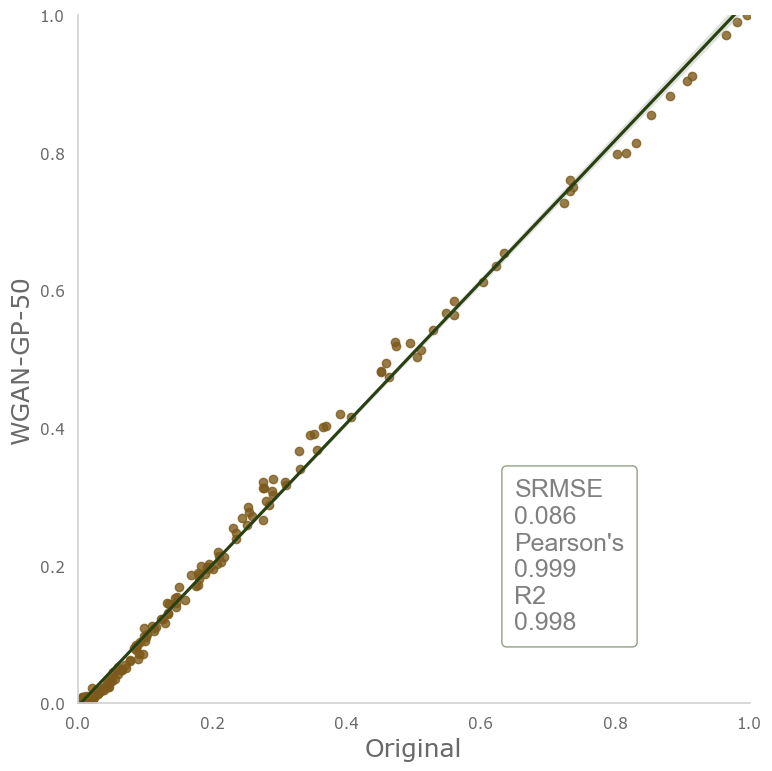

In [24]:
draw.plot_compare(data=combine,
                  title="compare",
                  model_type="categorical_fin_" + str(number_epochs) + "_lat_" + str(latent_dimension),
                  model=model,
                  model_name=model_name,
                  save=save_curve
                  )

# Plot Bland-Altman

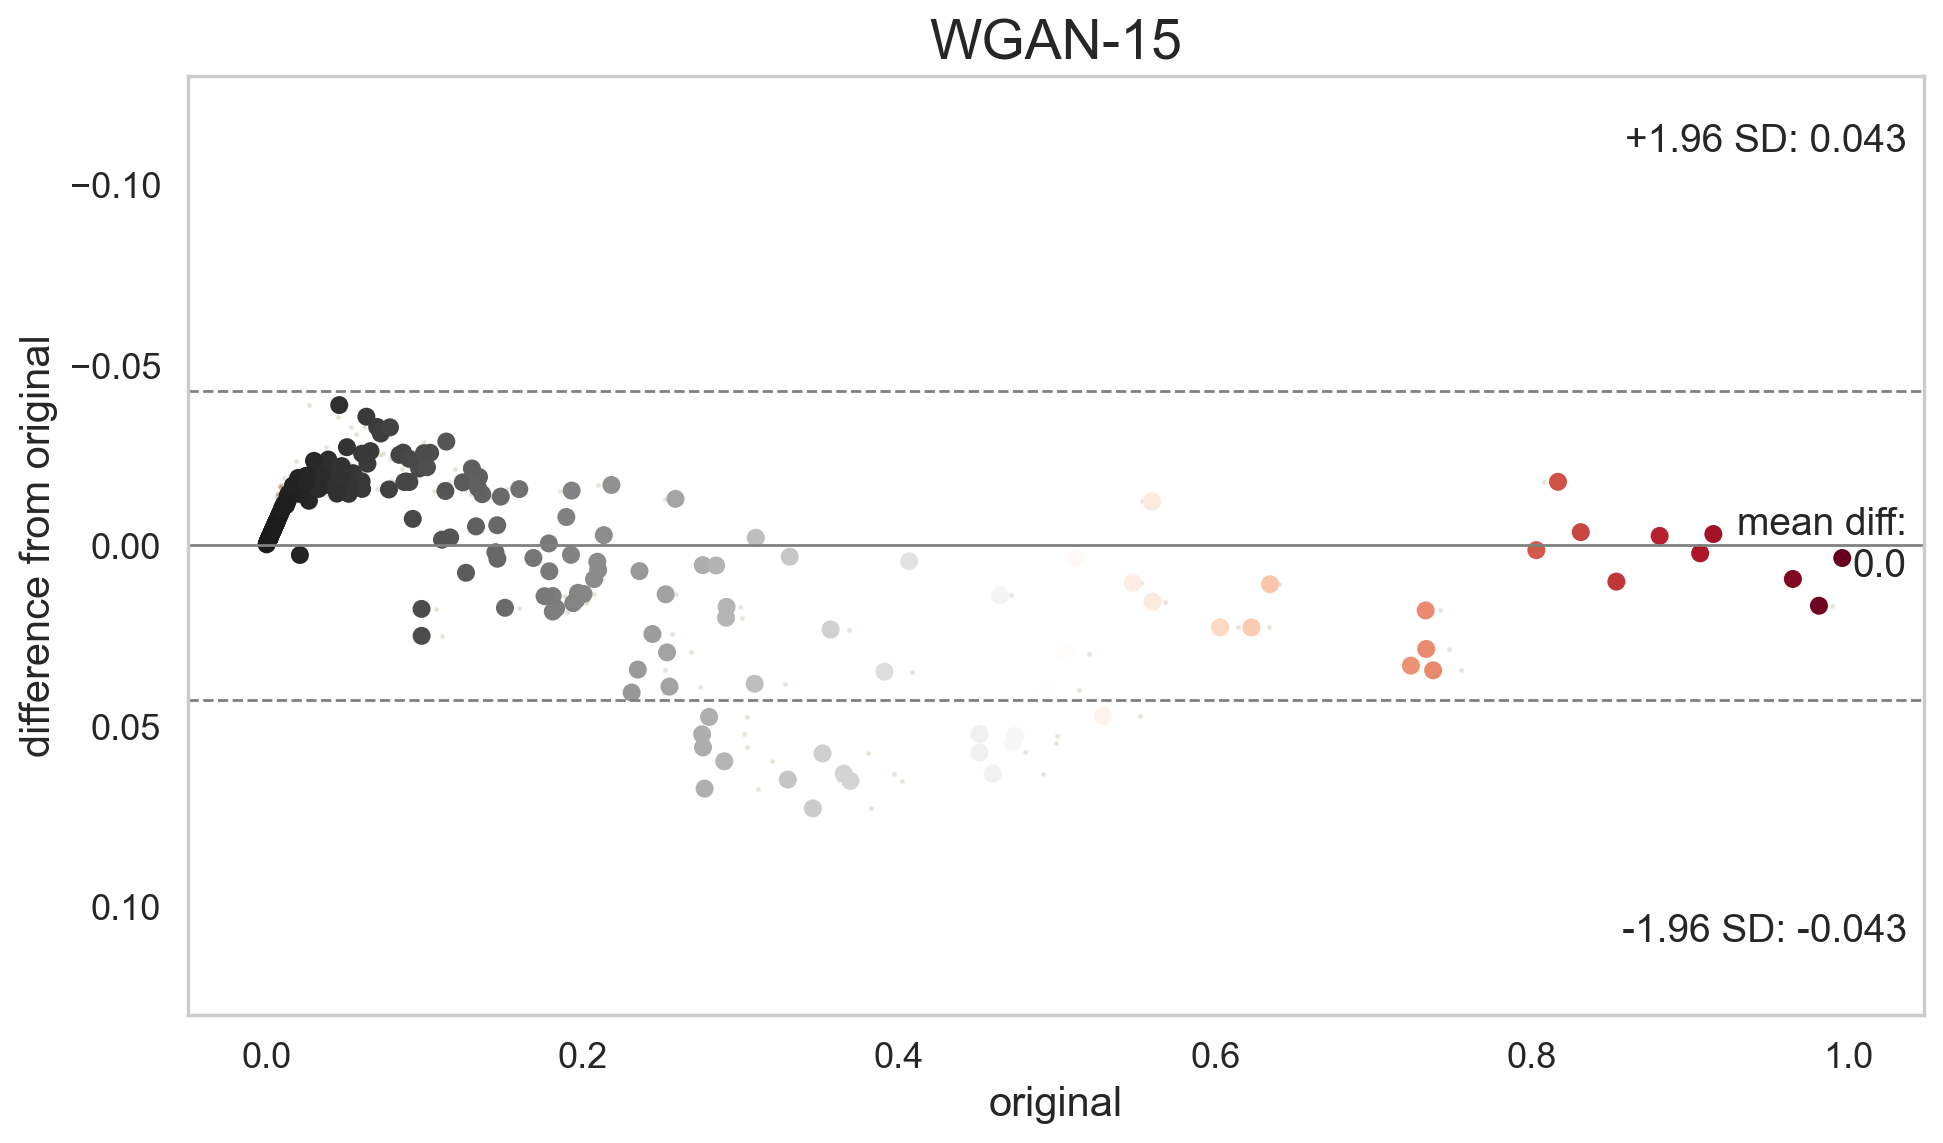

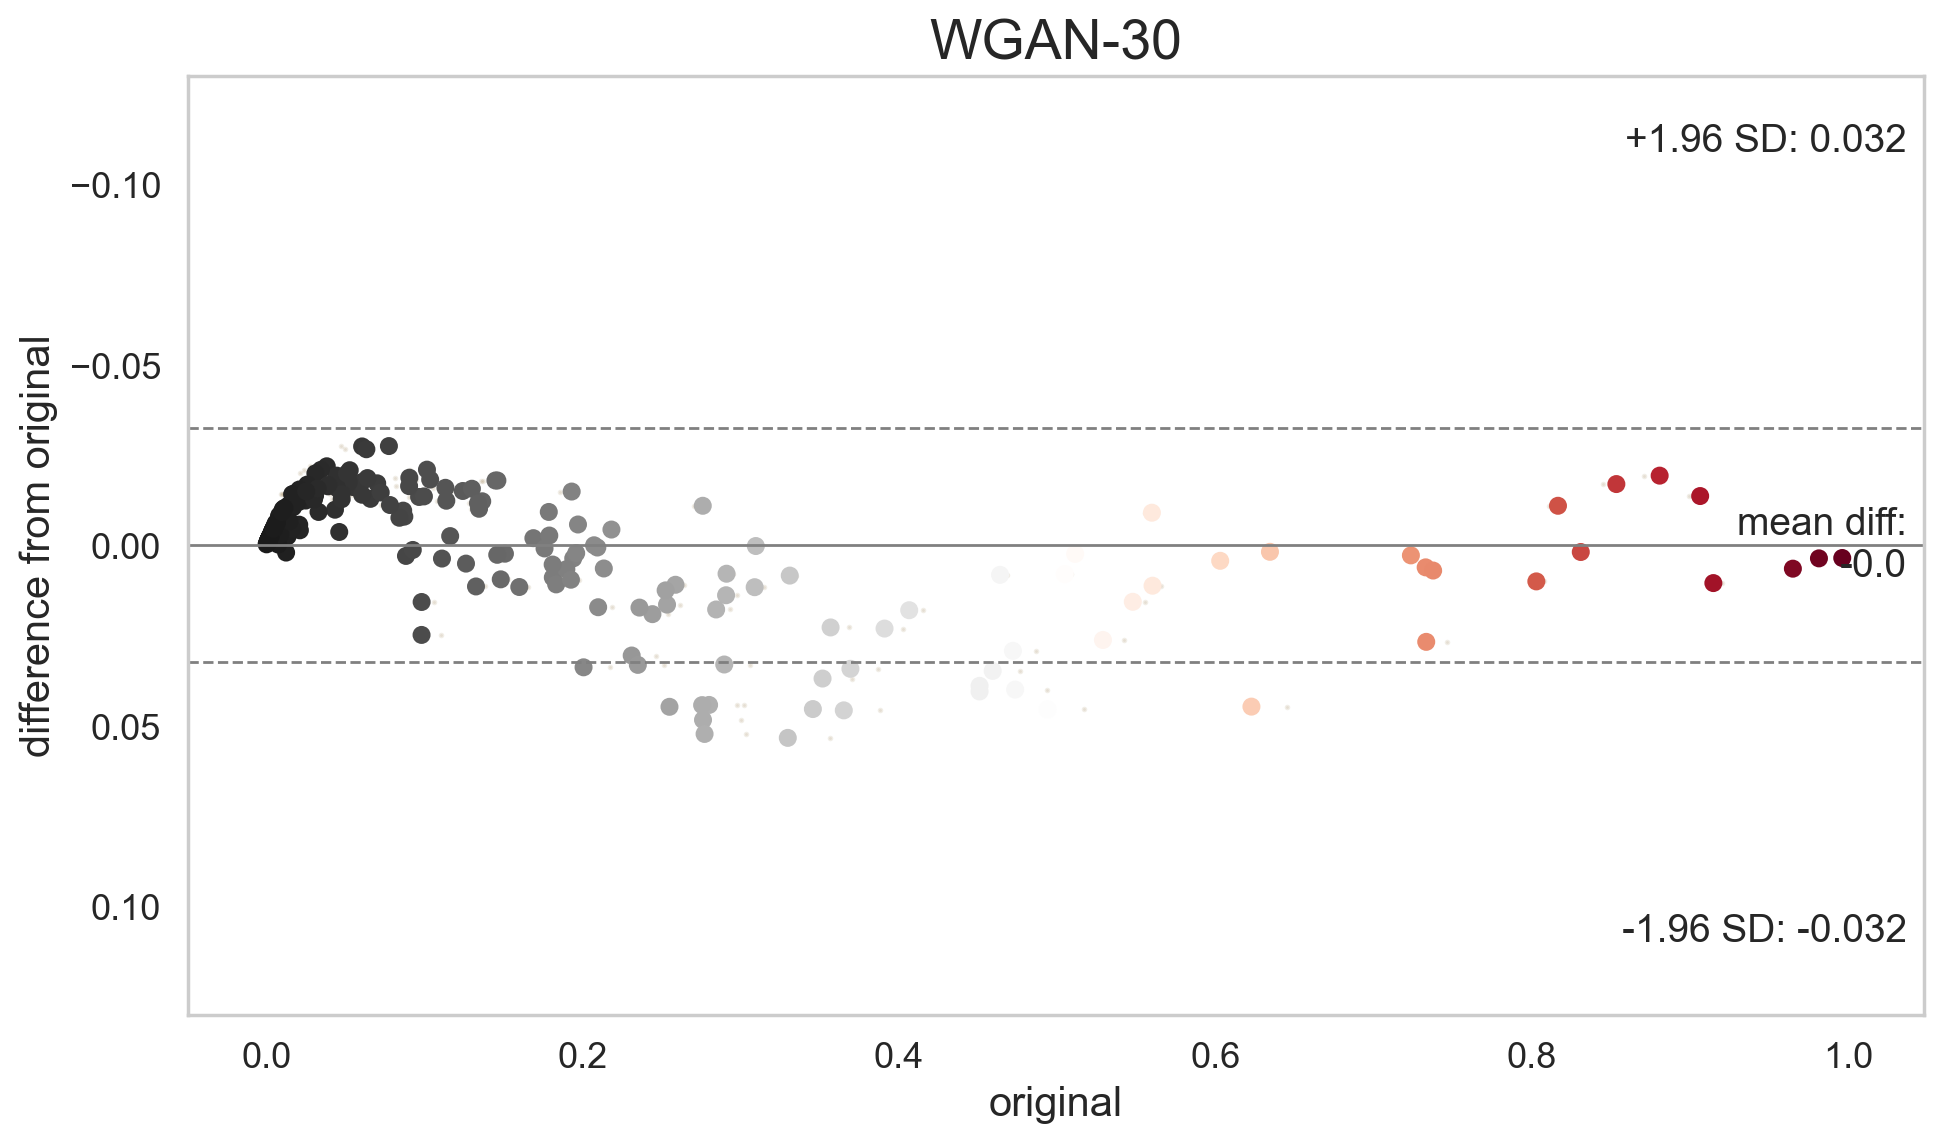

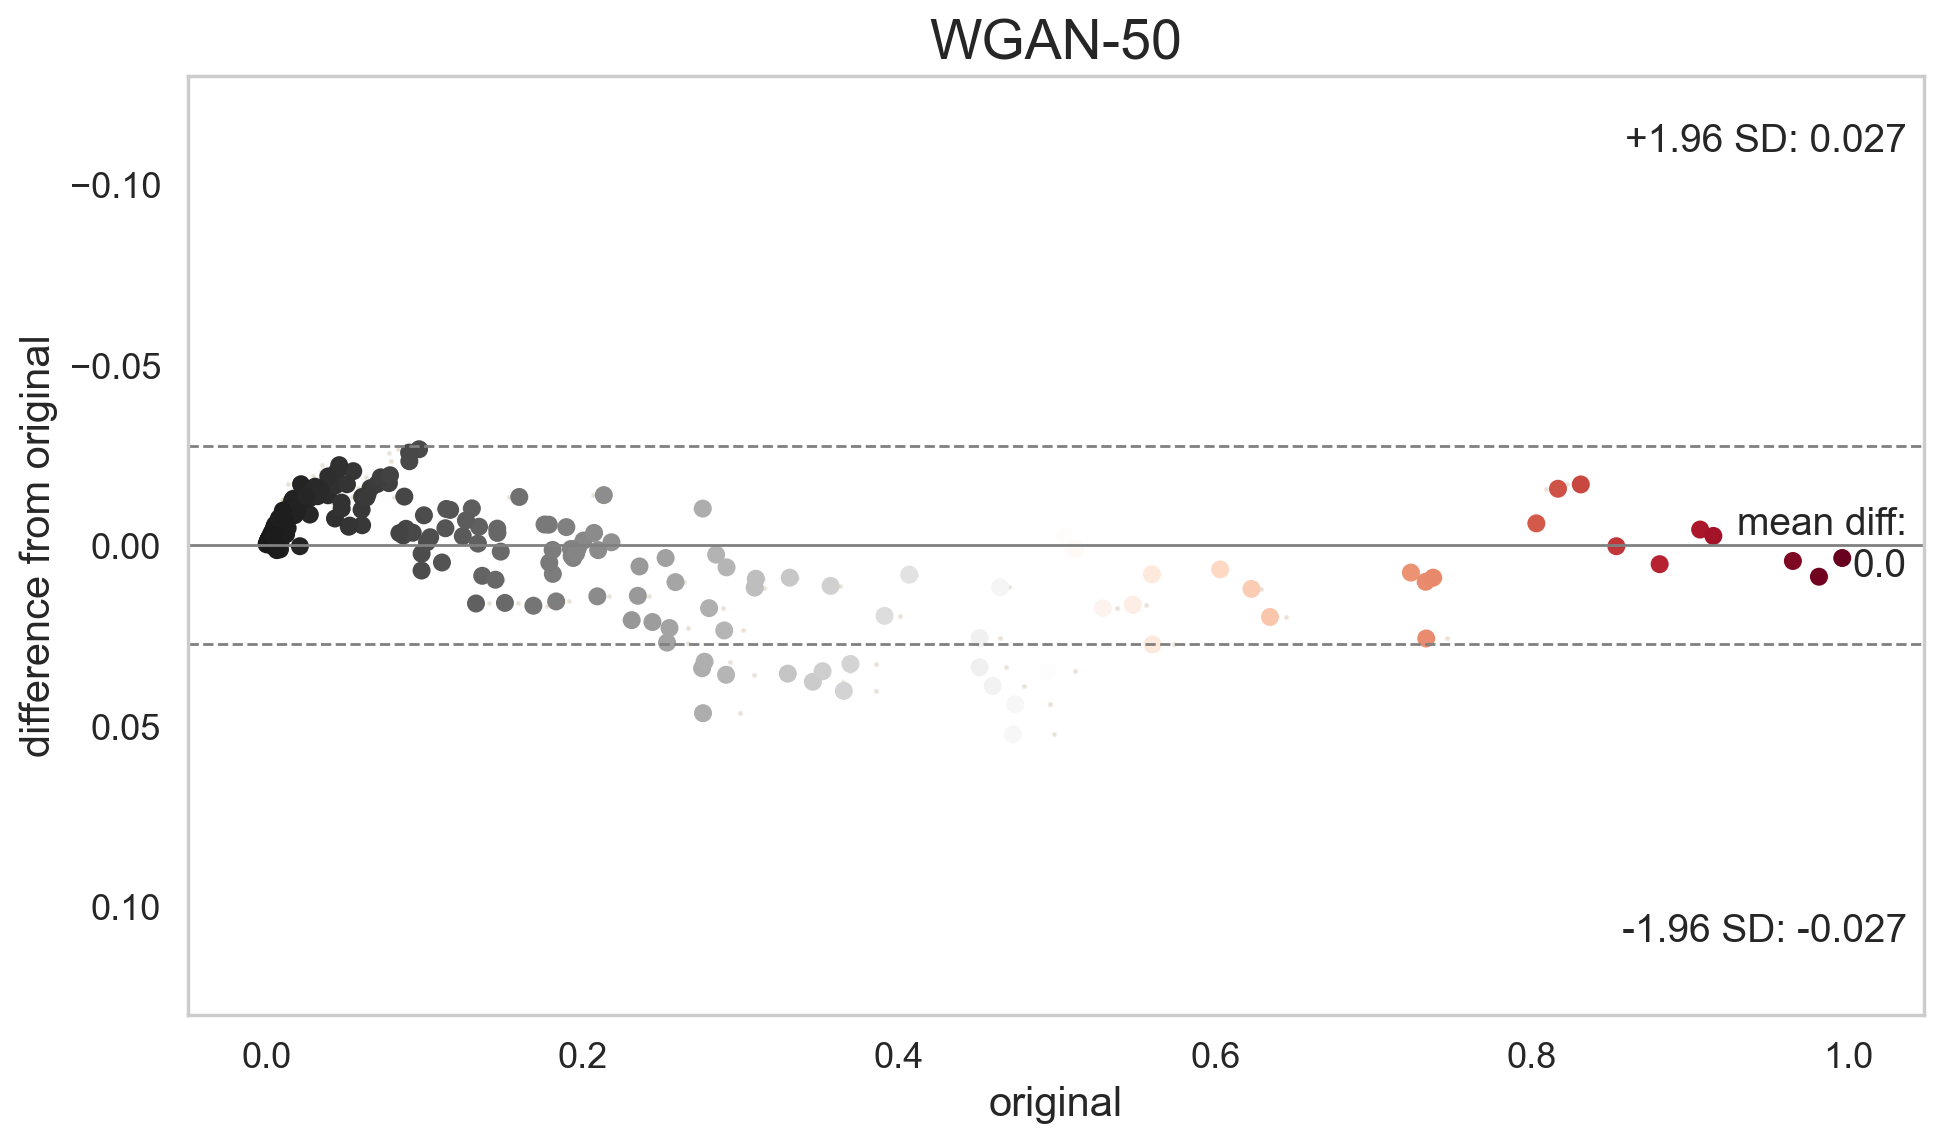

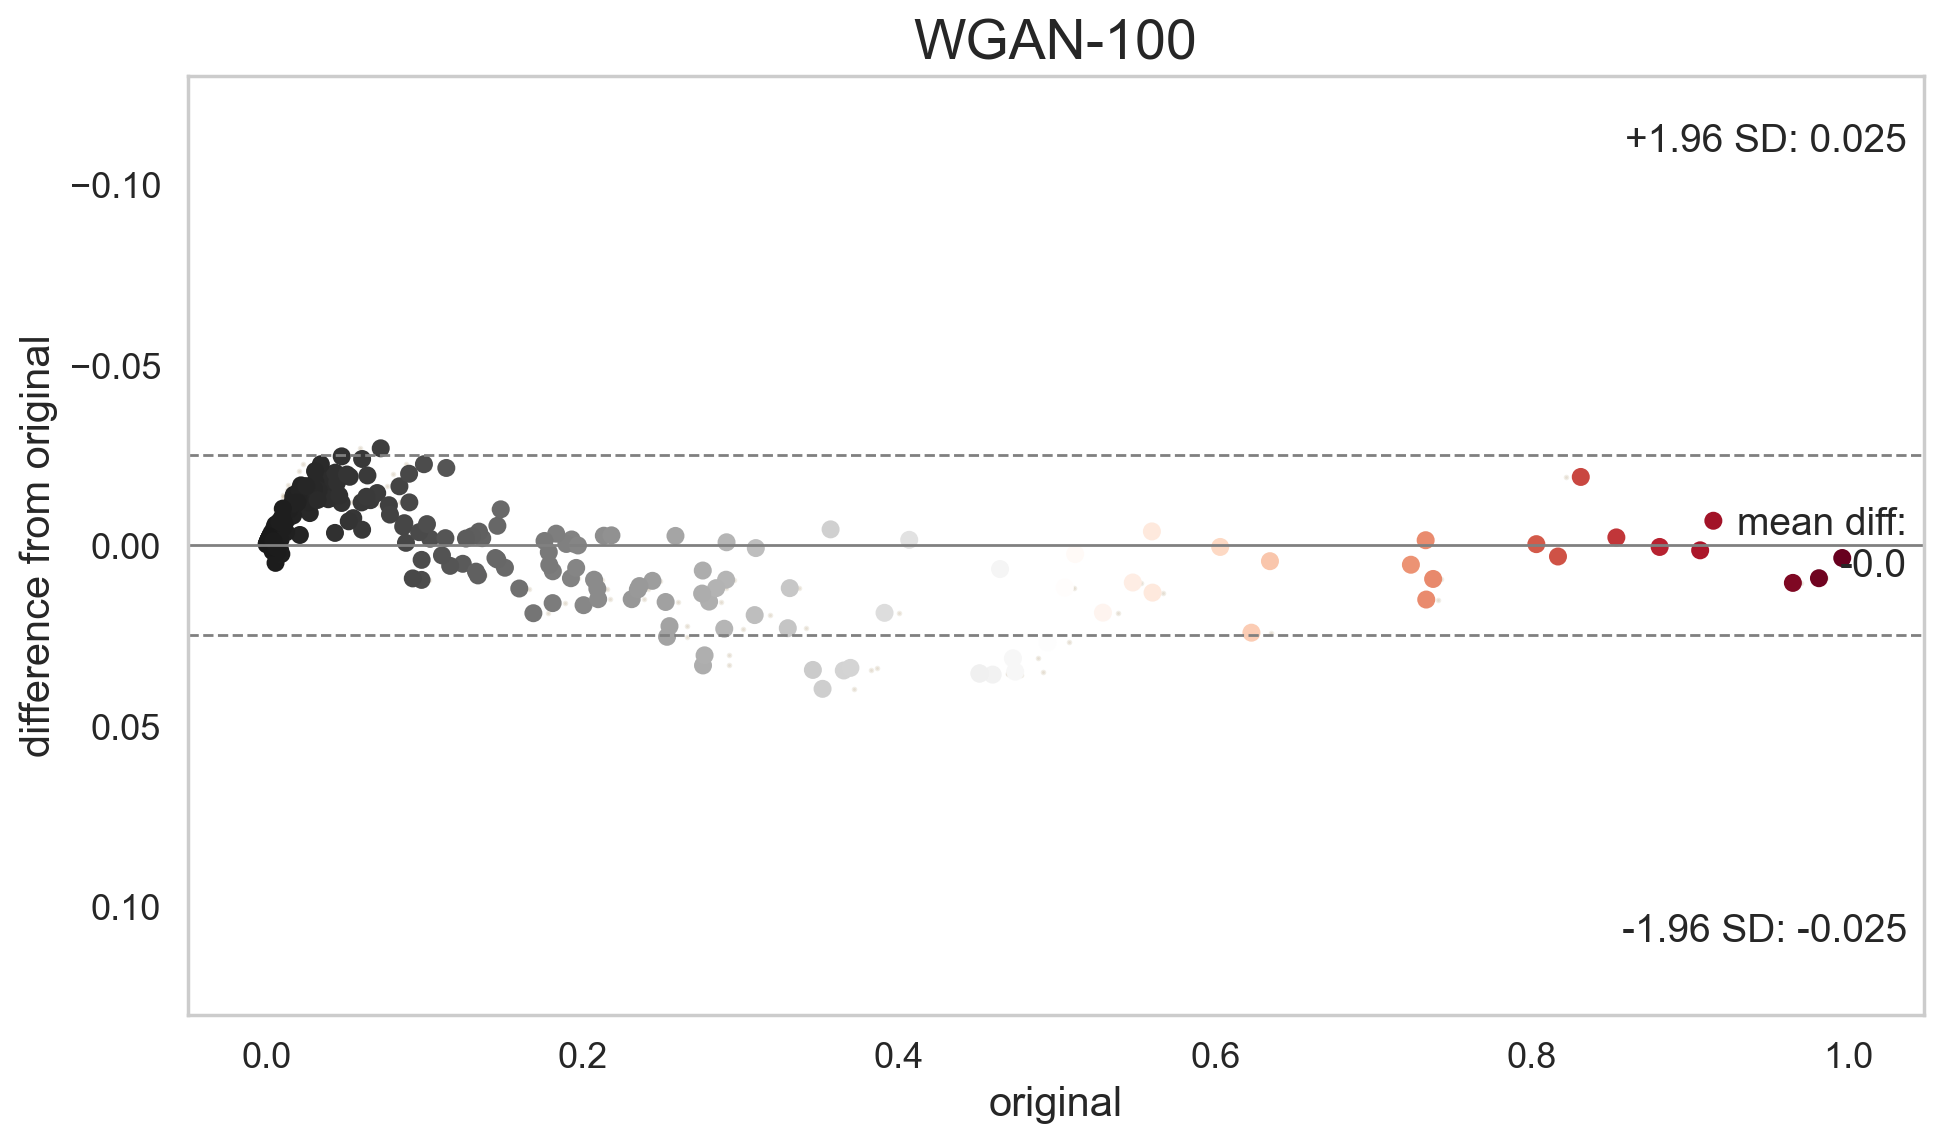

In [25]:
if reload:
    for i, mod in enumerate(model_collection):
        draw.color_bland_altman(df,
                                synthetic_collection[i],
                                title="WGAN-" + str(mod[0]),
                                model=model,  # Directory!!! --> figures/[model]/
                                model_type=model_type,
                                model_name=model_name,
                                difference_from="original",
                                save=save_curve
                                )

# Box Plots of Categorical Variables

<Figure size 640x480 with 0 Axes>

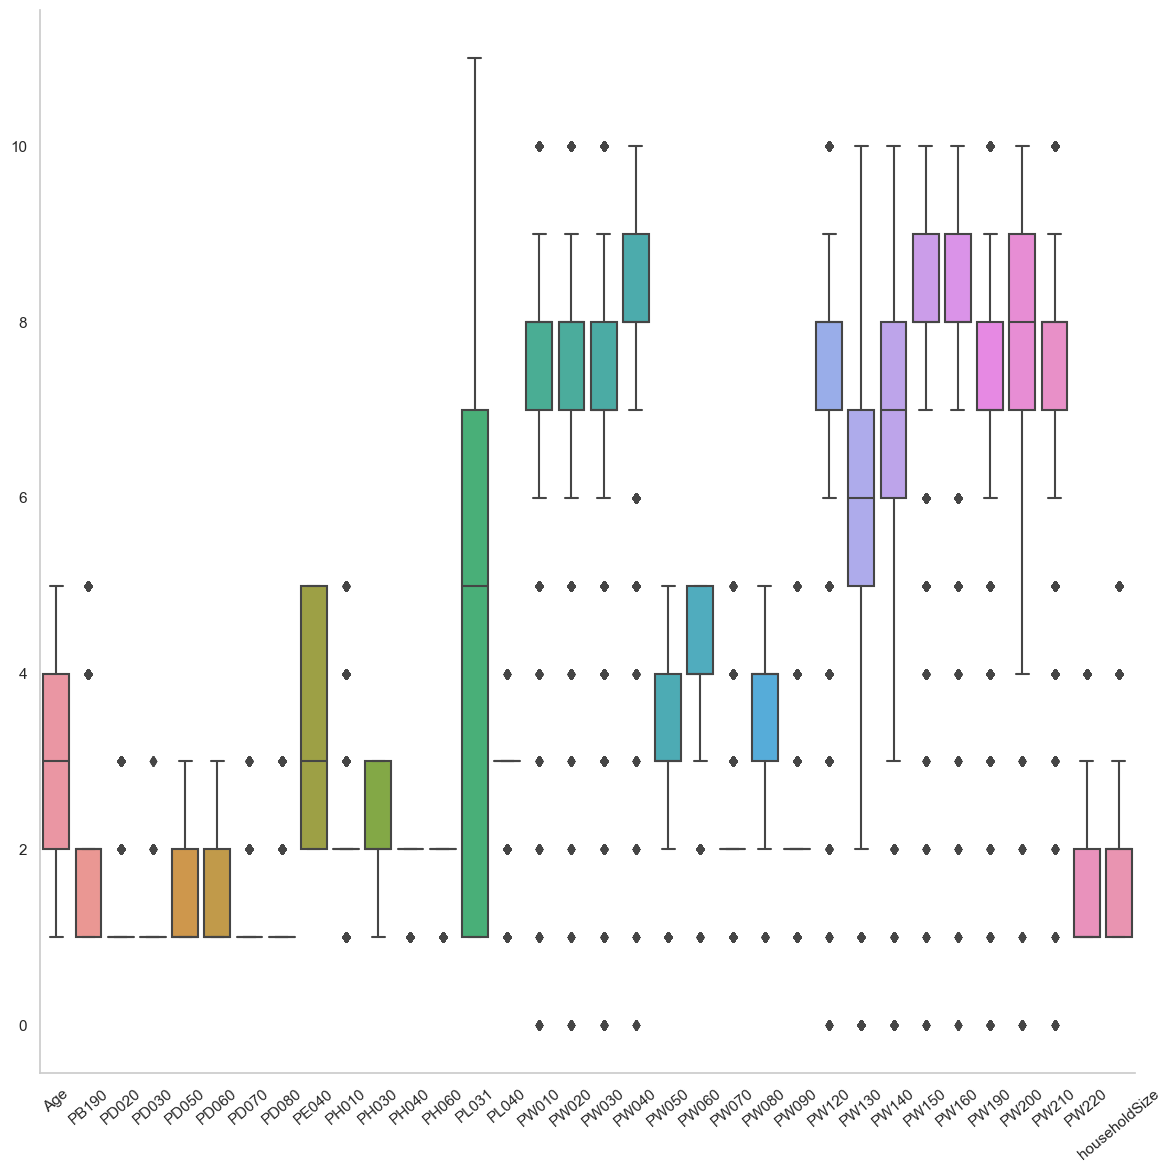

<Figure size 640x480 with 0 Axes>

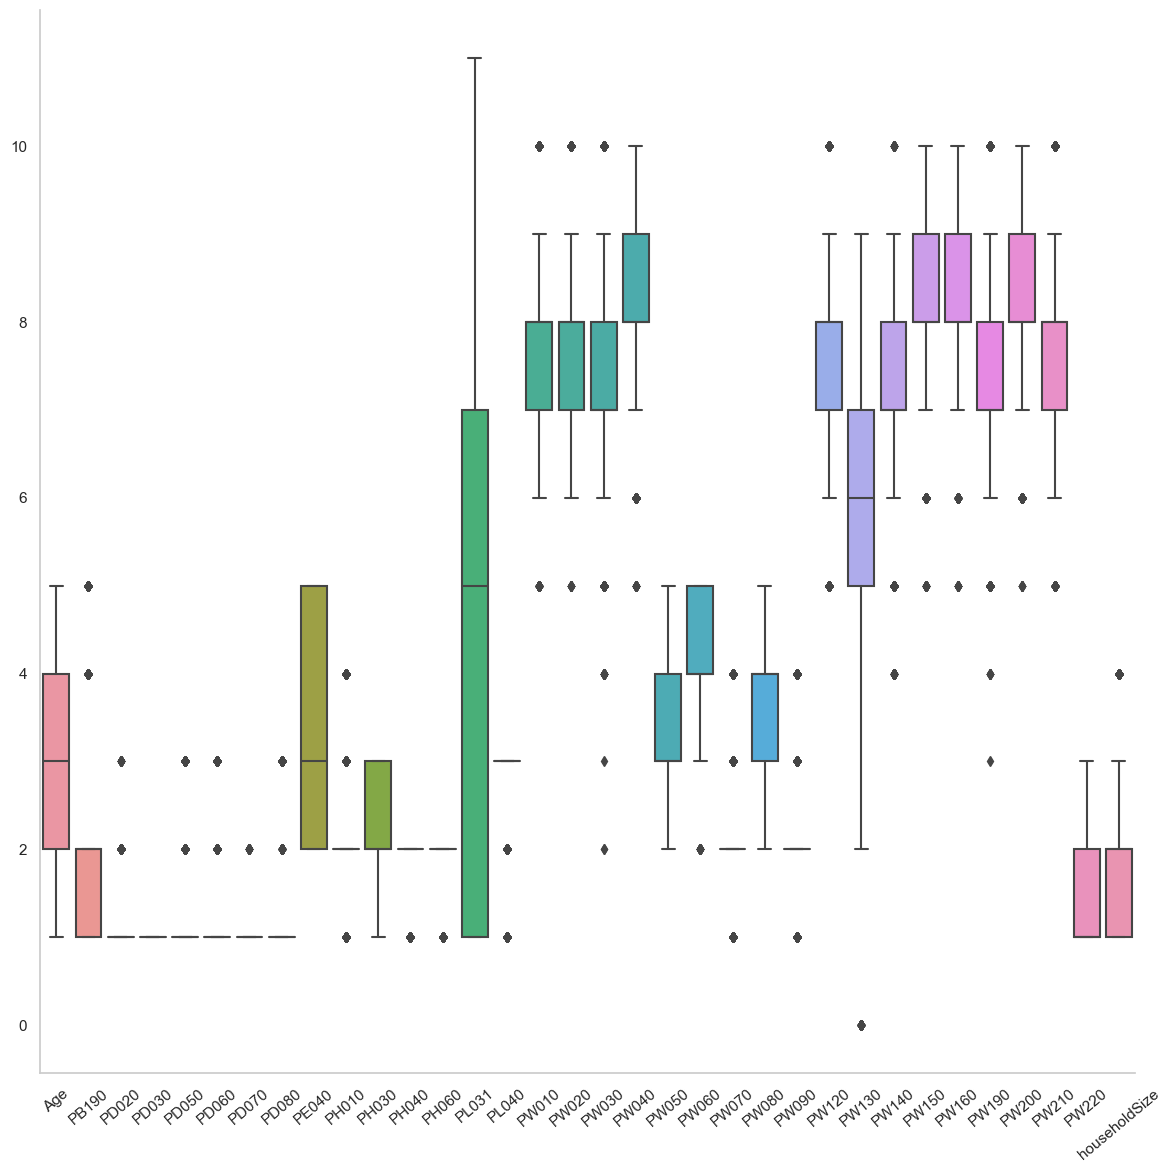

<Figure size 640x480 with 0 Axes>

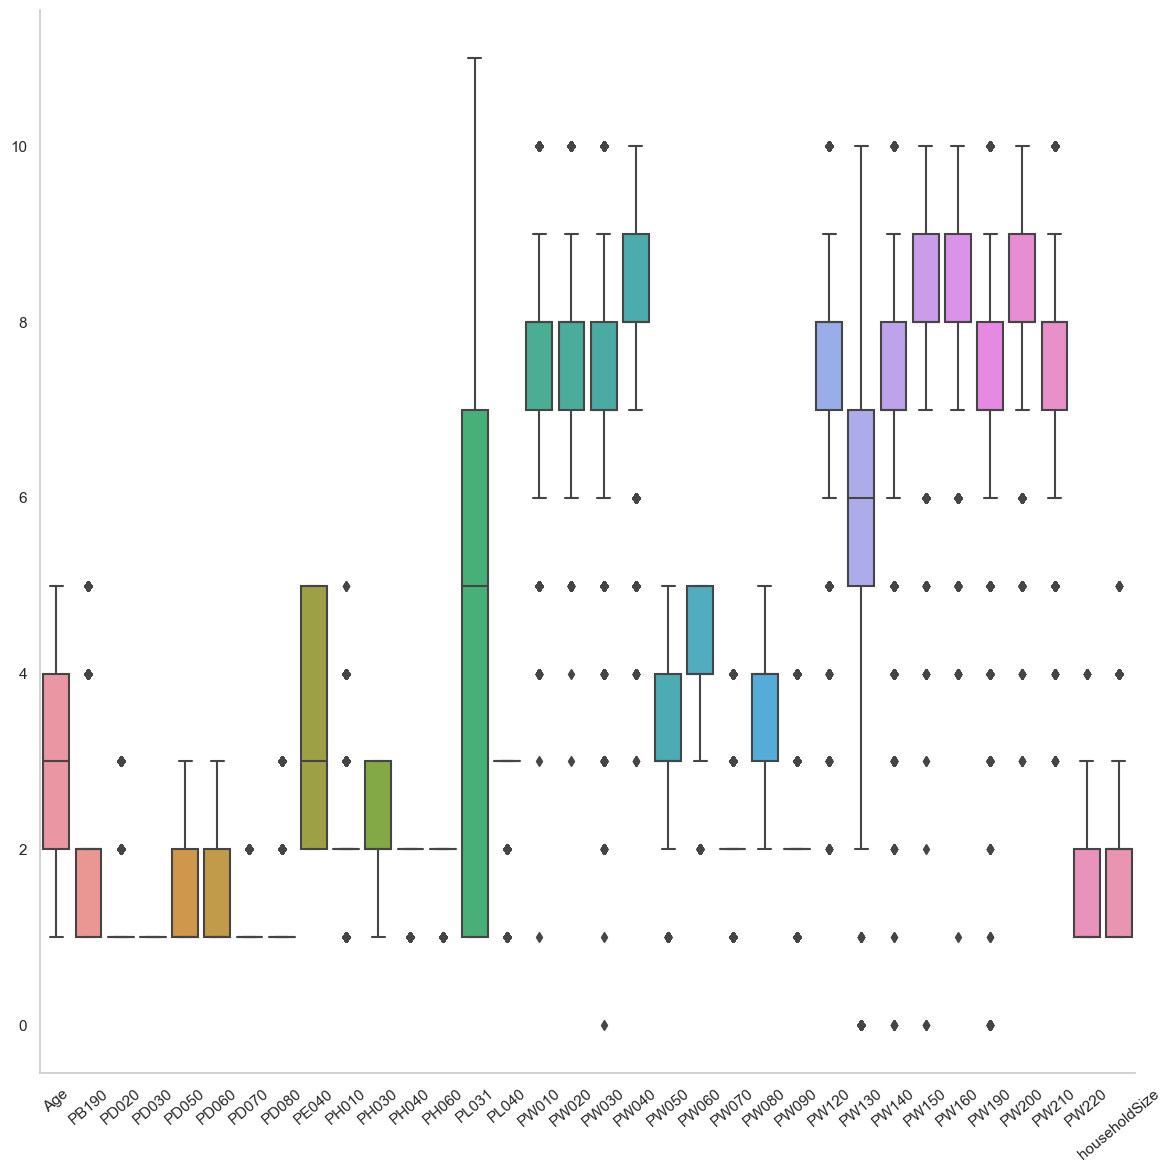

<Figure size 640x480 with 0 Axes>

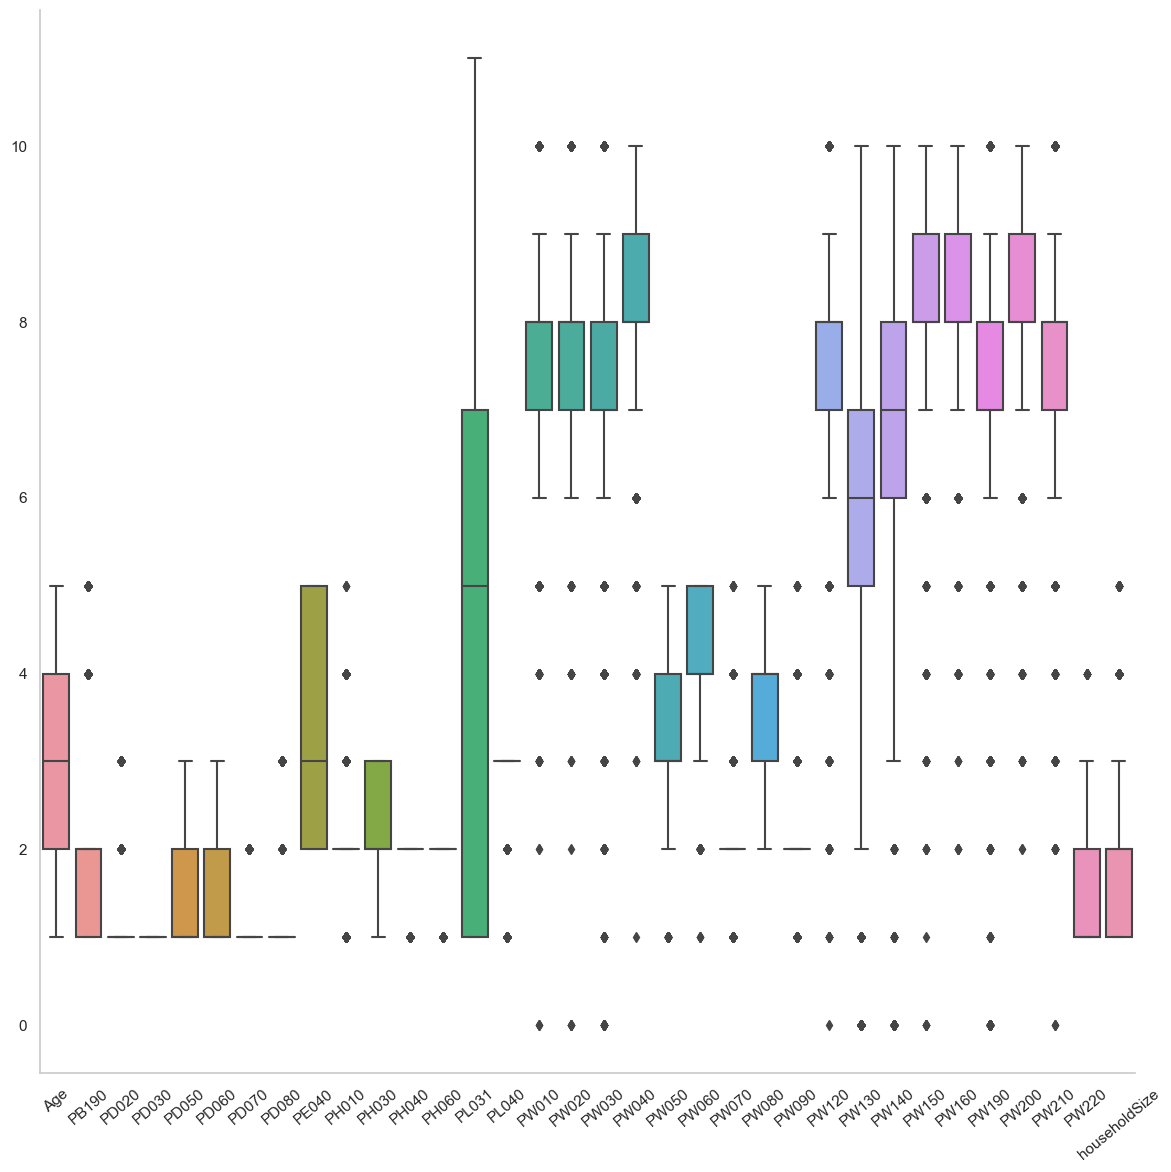

<Figure size 640x480 with 0 Axes>

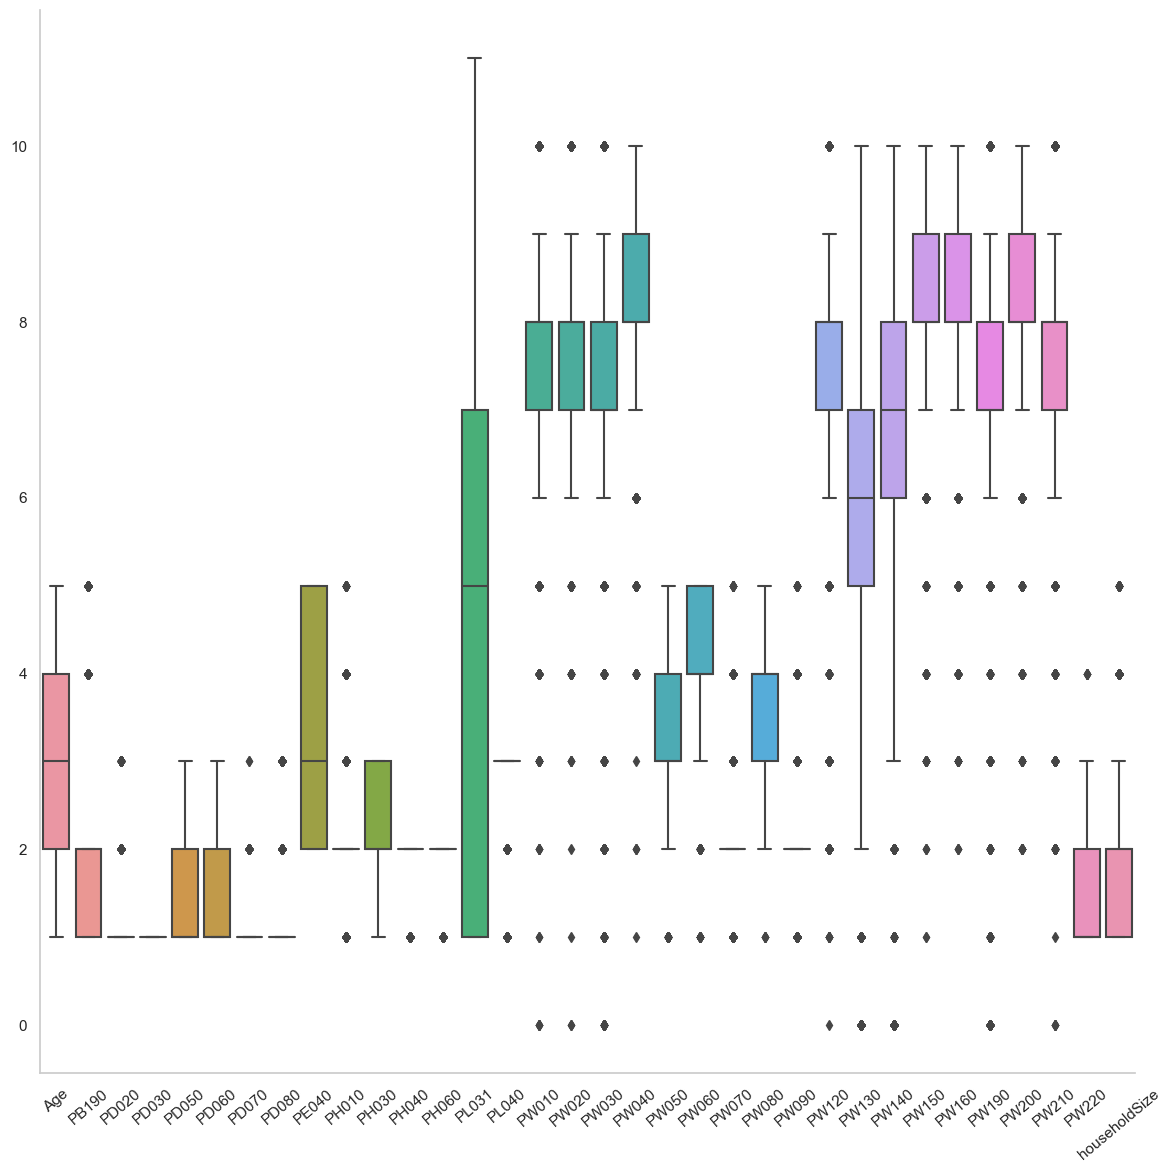

In [26]:
if reload:
    d_o_cat = data.get_data_recategorised()
    d_o_cat = d_o_cat.drop(data.binary, axis=1)
    draw.plot_catplot(d_o_cat,
                  title="Original-" + str(mod[0]),
                  model=model,  # Directory!!! --> figures/[model]/
                  model_type=model_type,
                  model_name=model_name,
                  save=save_curve
                  )
    for i, mod in enumerate(model_collection):
        d_cat = data.get_synthetic_recategorised(synthetic_collection[i], df.columns)
        d_cat = d_cat.drop(data.binary, axis=1)
        draw.plot_catplot(d_cat,
                          title="WGAN-" + str(mod[0]),
                          model=model,  # Directory!!! --> figures/[model]/
                          model_type=model_type,
                          model_name=model_name,
                          save=save_curve
                          )

In [27]:
fraction_o = df.mean(axis=0)
binary_o = fraction_o.values.reshape(-1, 1) * fraction_o.values.reshape(-1, 1).T
binary_o = binary_o[~np.eye(binary_o.shape[0],dtype=bool)].reshape(binary_o.shape[0],-1)  # Remove diagonal
fraction_synthetic = []
for s in synthetic_collection:
    frac = s[df.columns].mean(axis=0).values.reshape(-1, 1)
    binary = frac * frac.T
    binary = binary[~np.eye(binary.shape[0],dtype=bool)].reshape(binary.shape[0],-1)
    fraction_synthetic.append((frac, binary))

# Plot Binary Correlation Marginals

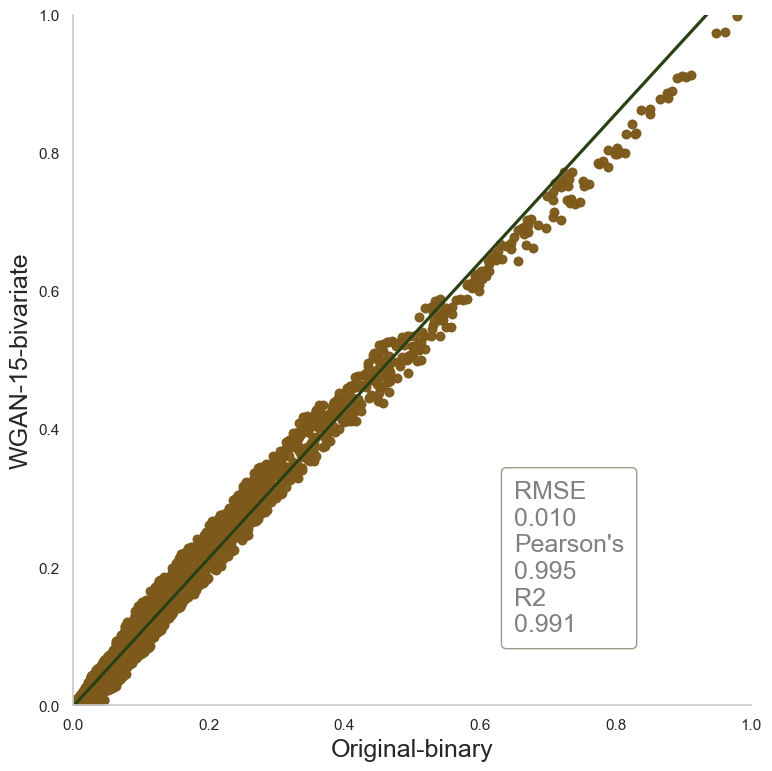

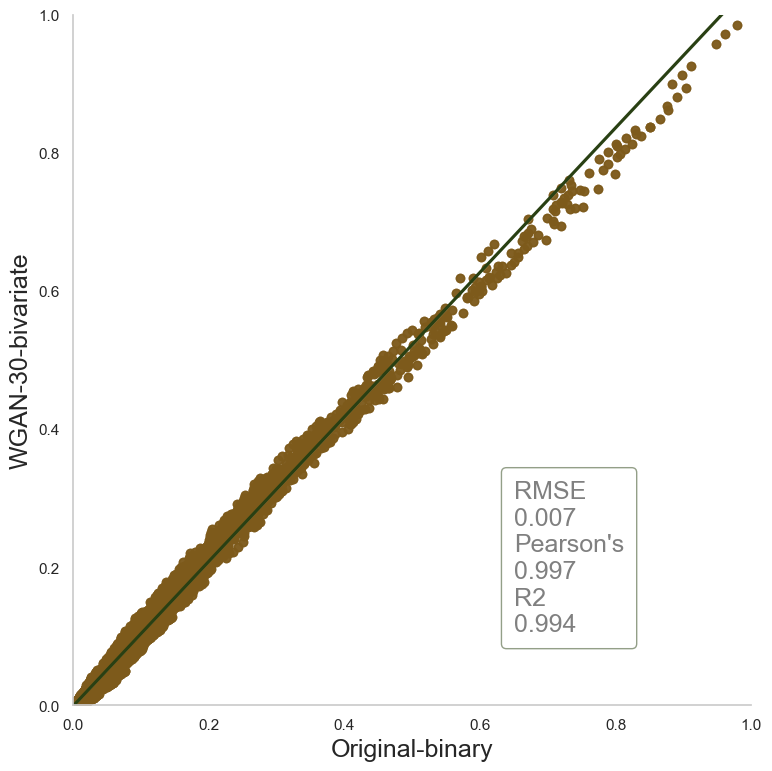

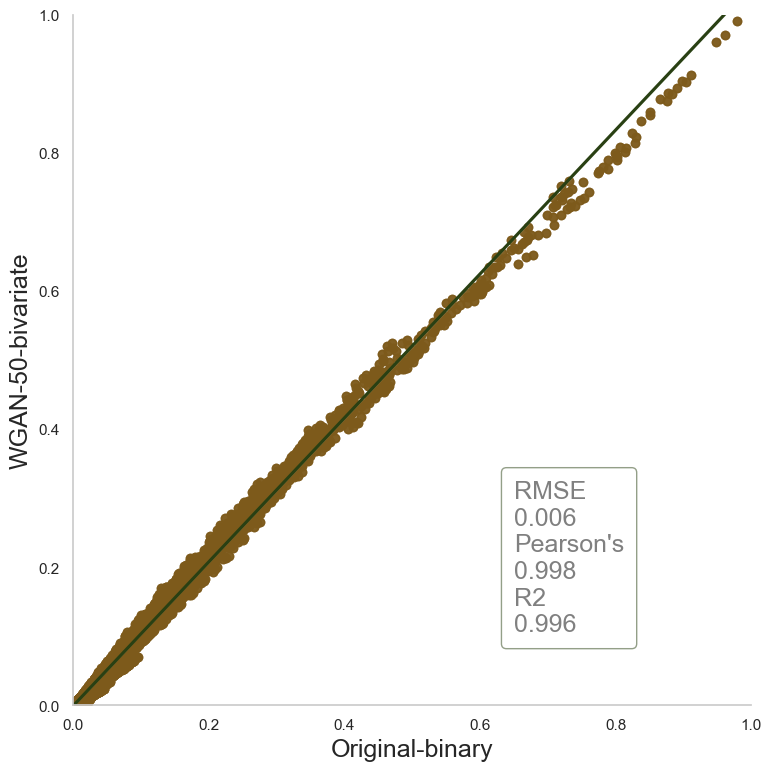

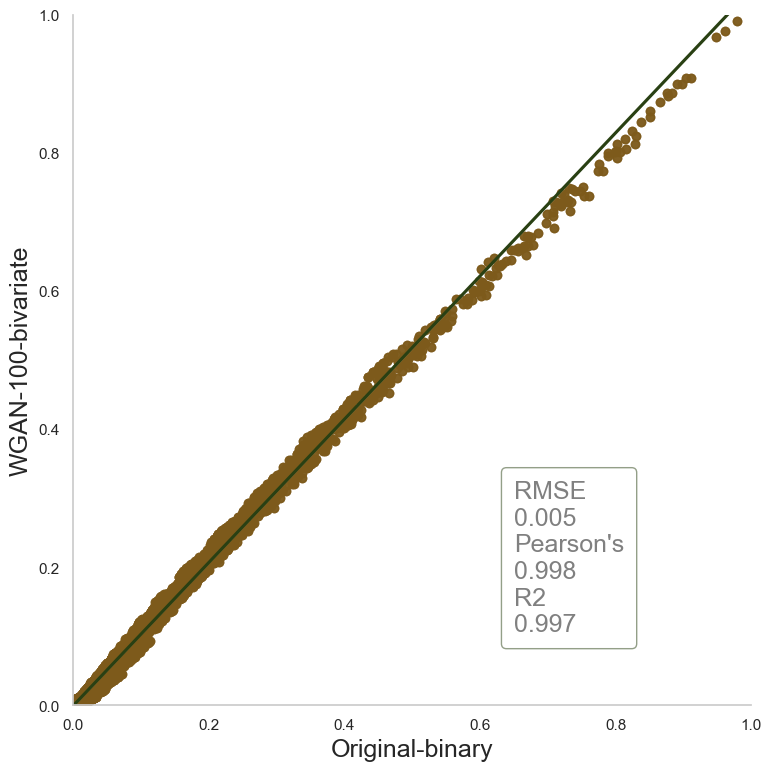

In [28]:
# Plot binary correlation calculated by cross-product - where the univariate diagonal is removed,
# keeping only the bivariate connections 
for (_, bi), lat  in zip(fraction_synthetic, gan_cfg["latent_dimensions"]):
    combine = pd.concat([pd.DataFrame(binary_o.flatten()), pd.DataFrame(bi.flatten())], axis=1)
    combine.columns = ["Original-binary", "WGAN-" + str(lat) + "-bivariate"]
    draw.plot_compare(data=combine,
                  title="compare",
                  model_type="bivariate_fin_" + "_lat_" + str(lat),
                  model=model,
                  model_name=model_name,
                  save=save_curve,
                  norm_rmse=False
                  )

In [29]:
if not reload:
    x = []
    y = []
    z = []
    for tup in collect_loss:
        x.append(tup[0].detach().numpy())
        y.append(tup[1].detach().numpy())
        z.append(tup[2].detach().numpy())

In [30]:
if not reload:
    plt.plot(x[1::15], label="critic-loss")
    plt.xlabel('Epochs')
    plt.ylabel('Critic Loss')
    plt.legend()
    
    if save_curve:
        plt.savefig("figures/gan/fin/Critic_loss_" + str(number_epochs) + "_lat_" + str(latent_dimension) + ".png", dpi=200)
    plt.show()

In [31]:
if not reload:
    plt.plot(y[1::15], label="generator-loss")
    plt.xlabel('Epochs')
    plt.ylabel('Generator Loss')
    plt.legend()
   
    if save_curve:
        plt.savefig("figures/gan/fin/Generator_loss_" + str(number_epochs) + "_lat_" + str(latent_dimension) + ".png", dpi=200)
        
    plt.show()

In [32]:
if not reload:
    plt.plot(z[1::15], label="gradient-penalty")
    plt.xlabel('Epochs')
    plt.ylabel('Gradient Penalty')
    plt.legend()
    
    if save_curve:
        plt.savefig("figures/gan/fin/GP_loss_" + str(number_epochs) + "_lat_" + str(latent_dimension) + ".png", dpi=200)
        
    plt.show()

In [33]:
generator_name = ("models/wgan/fin/gp-generator_lr_" + str(learning_rate) +
                  "_epochs_" + str(number_epochs) + 
                  "_c-iter_" + str(critic_iterations) +
                  "_leaky_02_" +
                  "_output_dim_1" +
                  "_feature_dim_" + str(feature_dimension) +
                  "_lat_" + str(latent_dimension) +
                  "_optimiser_" + optimiser_name)
critic_name = ("models/wgan/fin/gp-critic_lr_" + str(learning_rate) +
               "_epochs_" + str(number_epochs) + 
               "_c-iter_" + str(critic_iterations) +
               "_leaky_02" +
               "_feature_dim_" + str(feature_dimension) +
               "_lat_dim_" + str(latent_dimension) +
               "_output_dim_1_" +
                "_optimiser_" + optimiser_name)
save_opt_critic_name = ("models/wgan/fin/" + optimiser_name +
                        "_epochs_" + str(number_epochs) +
                        "_critic_lr_" + str(learning_rate) + "_" + 
                        str(beta_1) + "_" + str(beta_2) +
                        "_feature_dim_" + str(feature_dimension) +
                        "_lat_dim_" + str(latent_dimension))
save_opt_gen_name = ("models/wgan/fin/" + optimiser_name +
                     "_epochs_" + str(number_epochs) +
                     "_generator_lr_" + str(learning_rate) + "_" + 
                     str(beta_1) + "_" + str(beta_2) +
                     "_feature_dim_" + str(feature_dimension) +
                    "_lat_dim_" + str(latent_dimension))

In [34]:
if not reload:
    torch.save(generator.state_dict(), generator_name + ".pth")
    torch.save(critic.state_dict(), critic_name + ".pth")
    torch.save(opt_critic.state_dict(), save_opt_critic_name + "_.pth")
    torch.save(opt_generator.state_dict(), save_opt_gen_name + ".pth")

# Plot Single Variables Marinals with isFemale for Visual Binary Check

In [35]:
df_o_cat = data.get_data_recategorised()
df_s_cat = data.get_synthetic_recategorised(torch_synthetic.detach().numpy(), columns=df_o.columns)

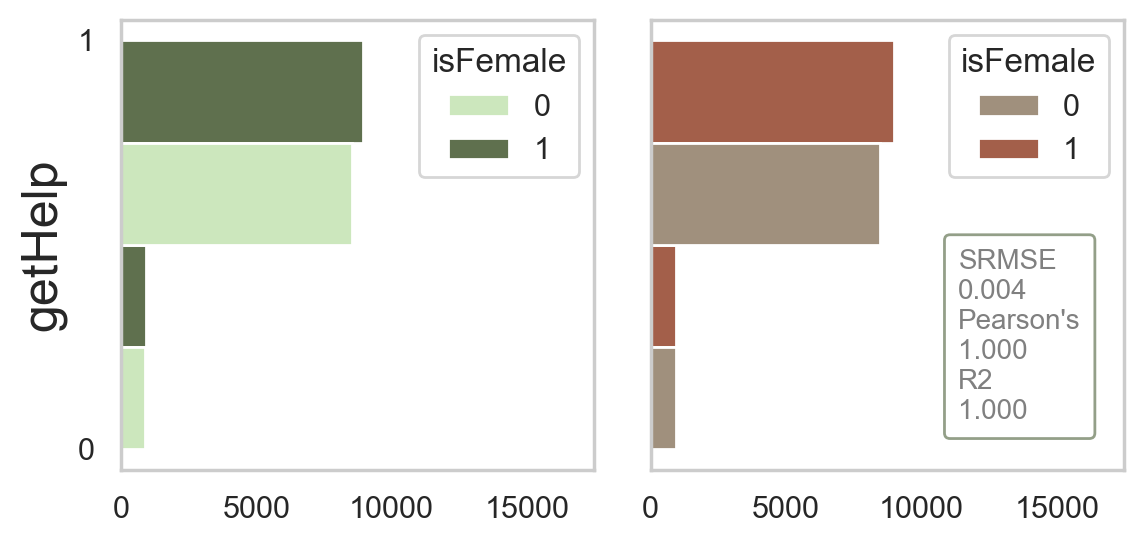

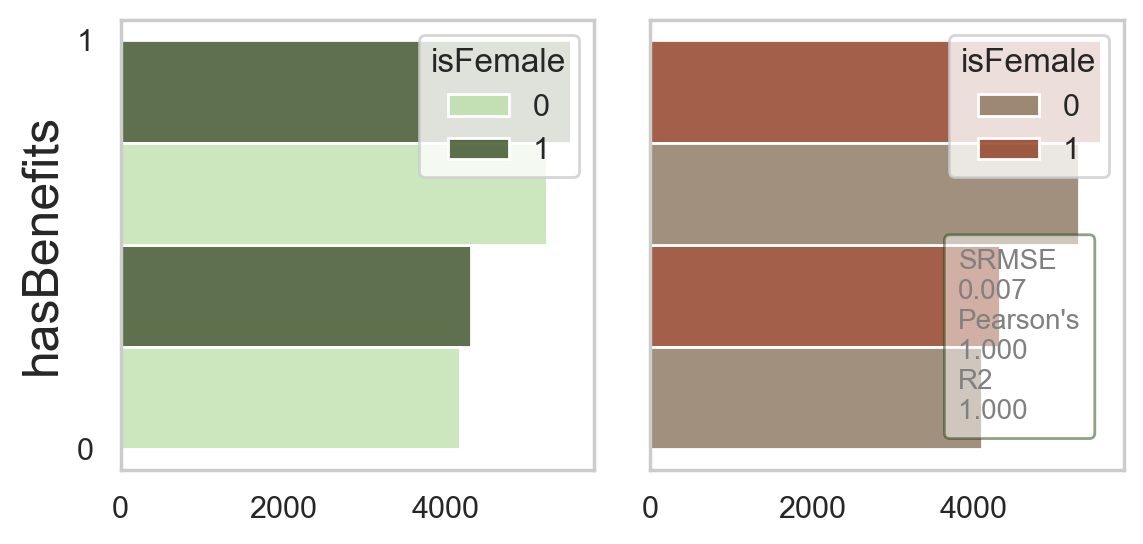

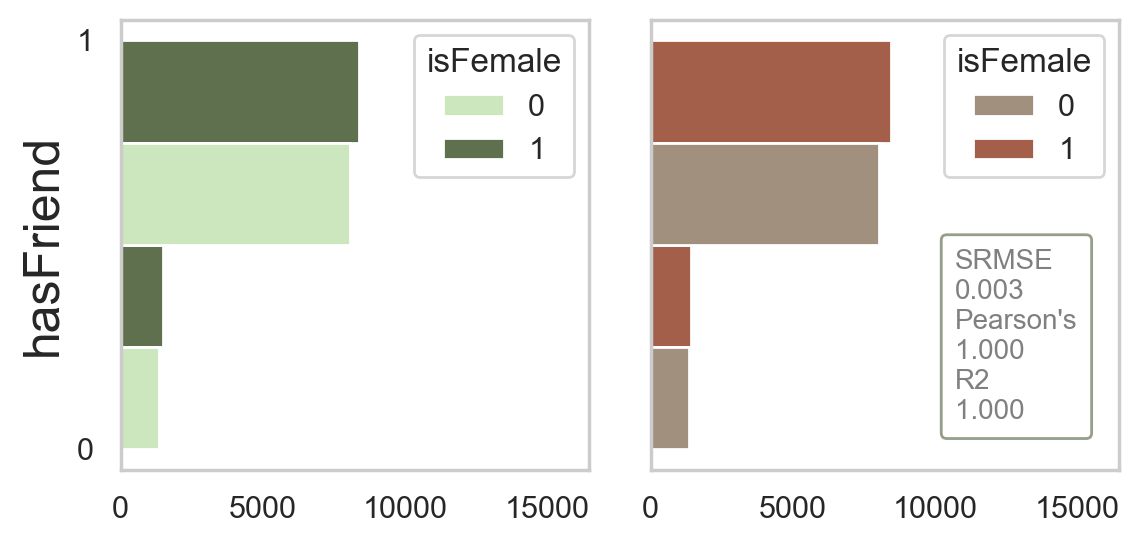

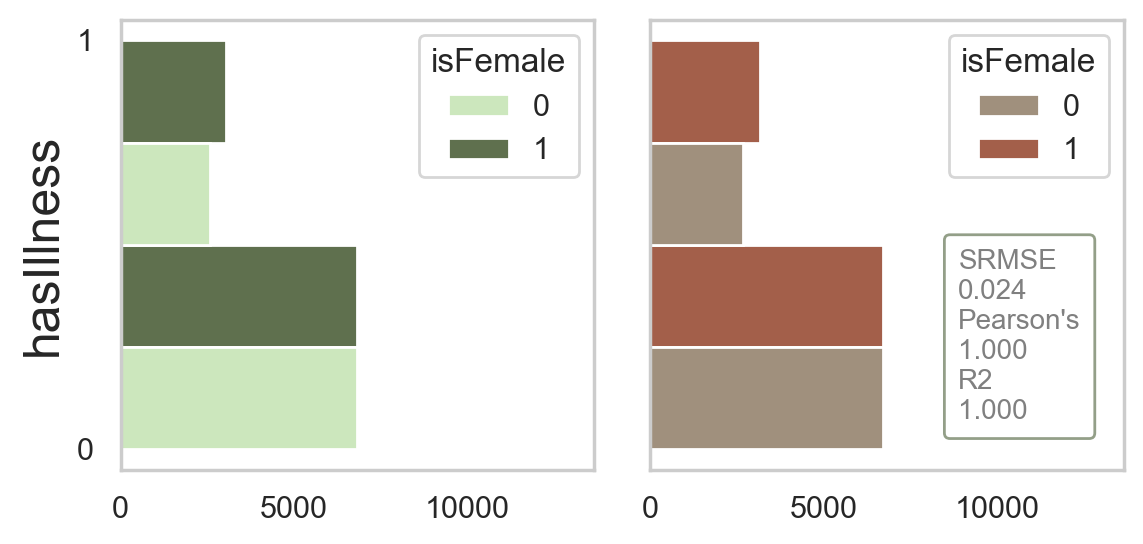

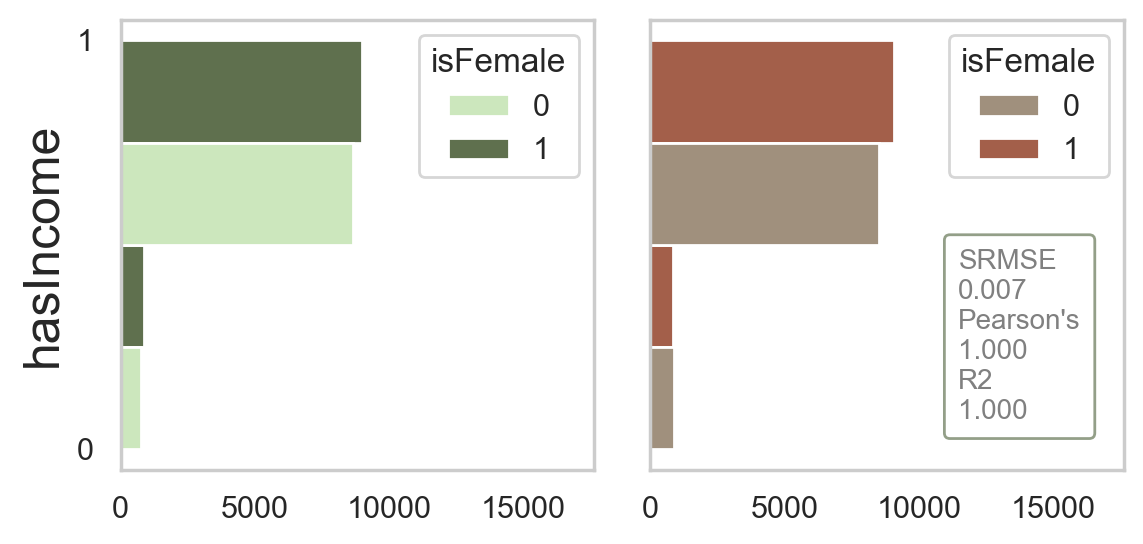

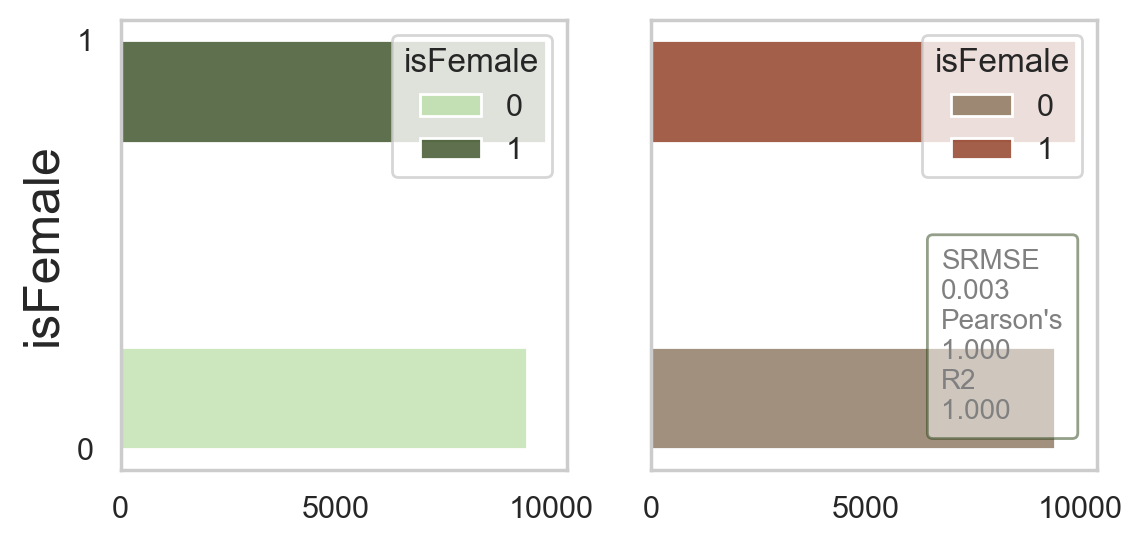

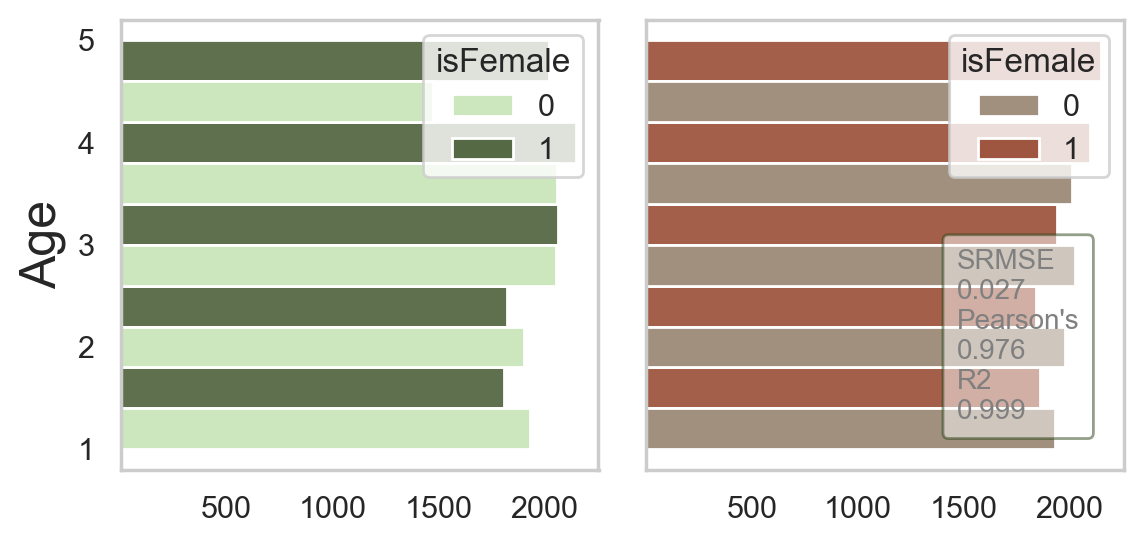

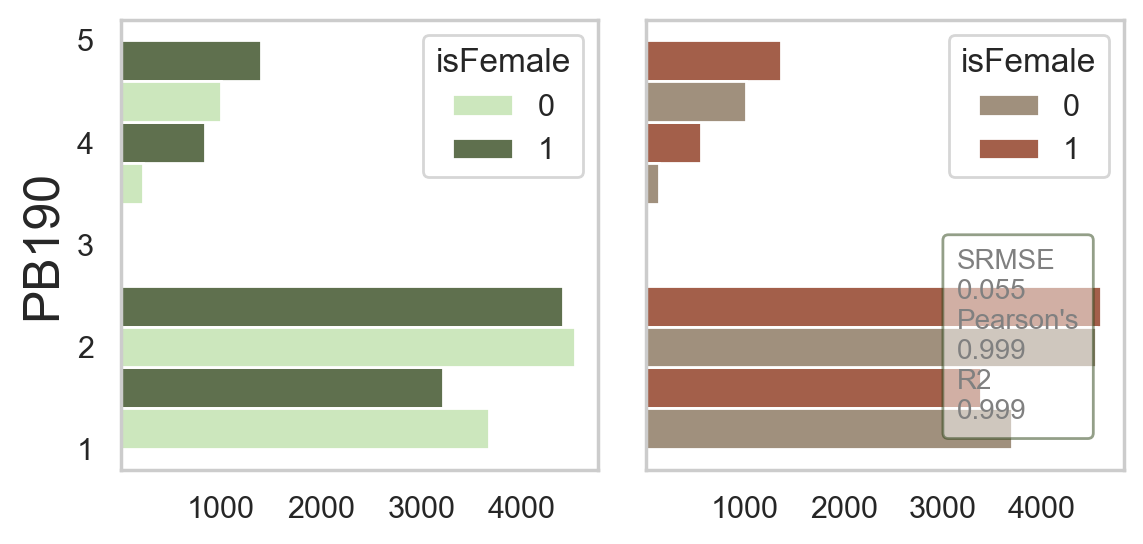

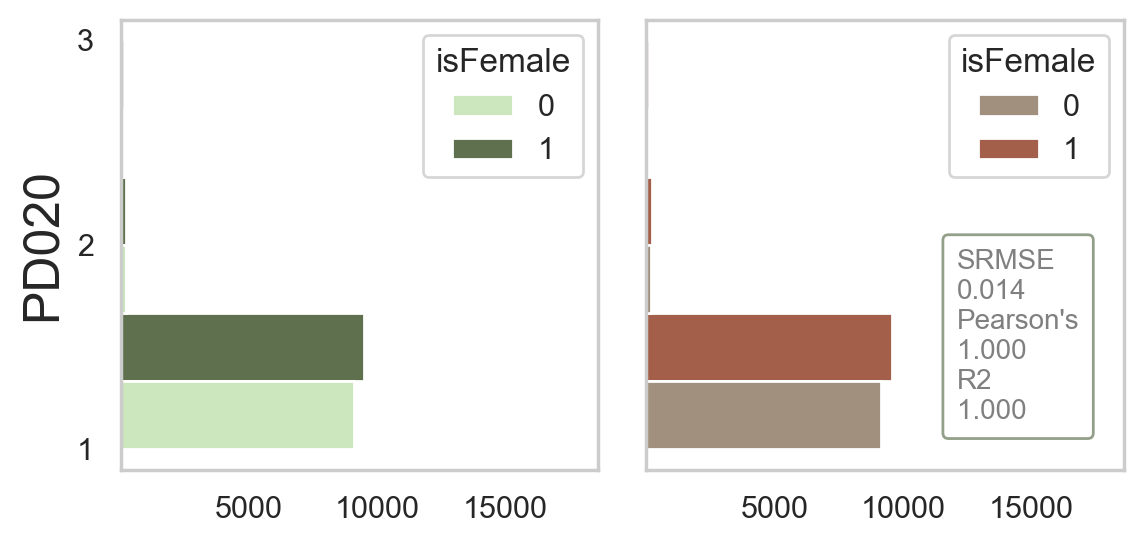

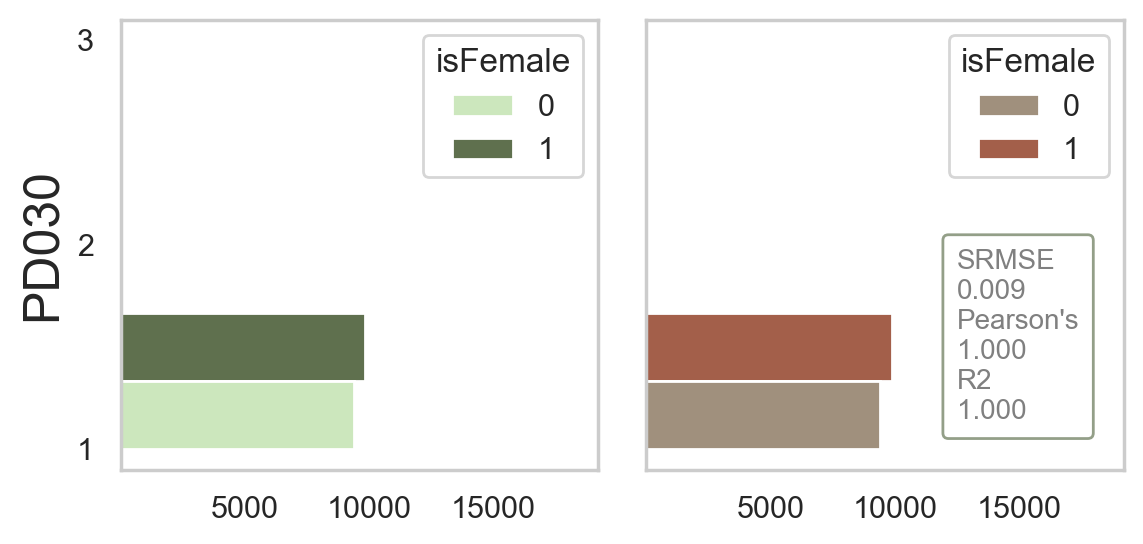

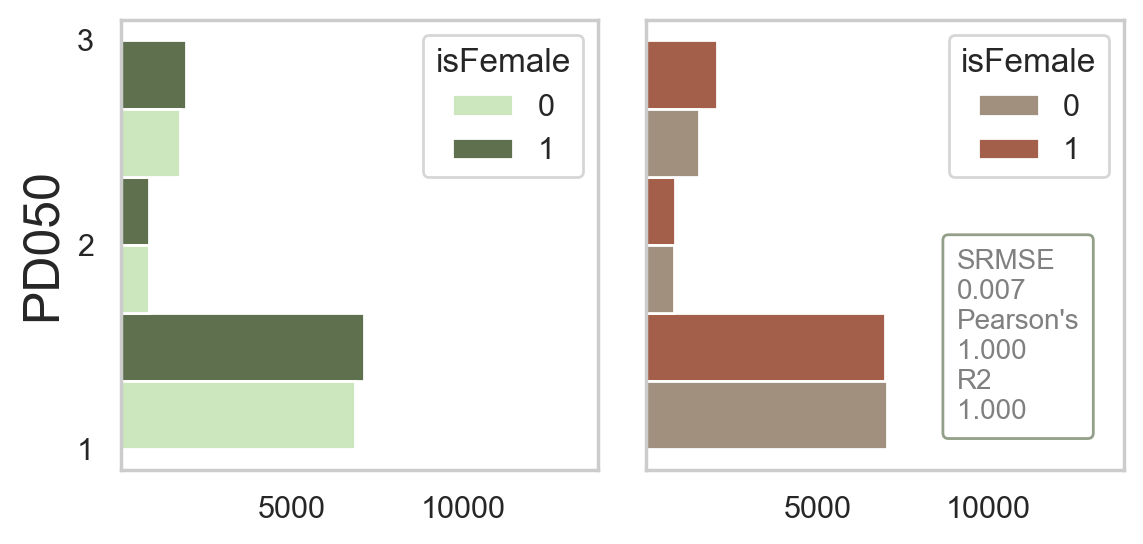

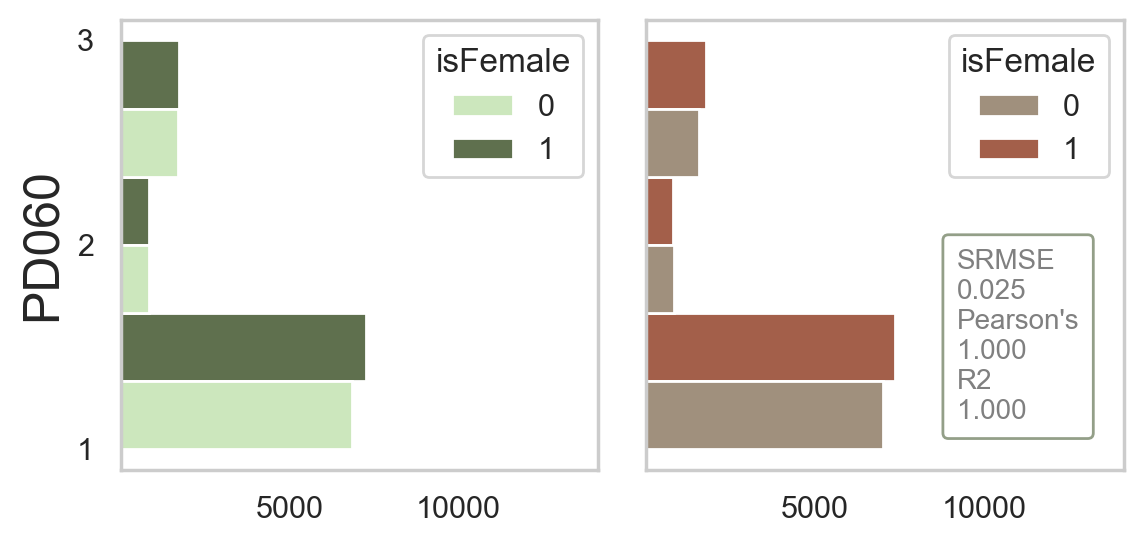

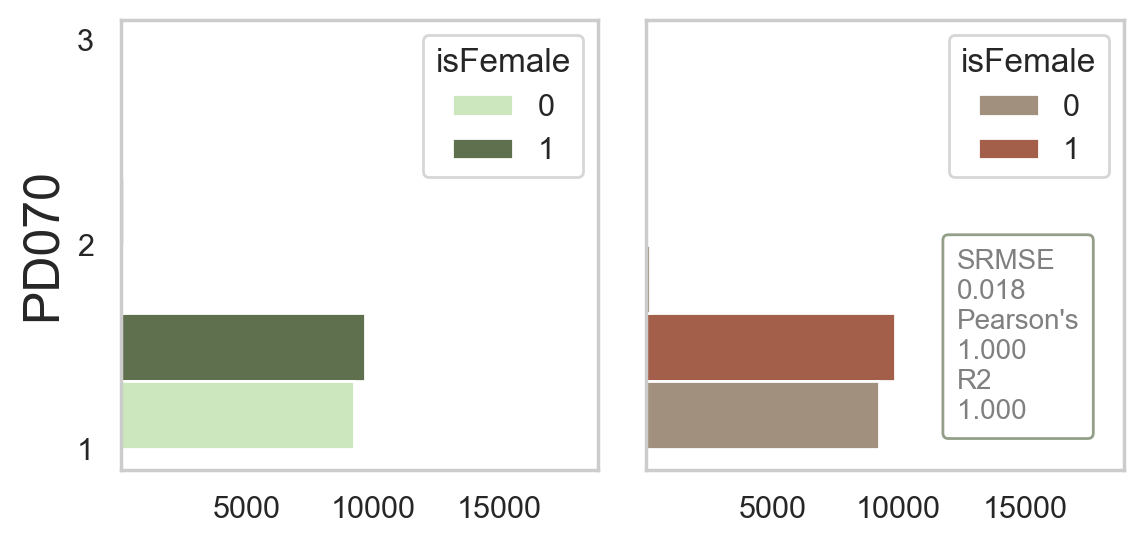

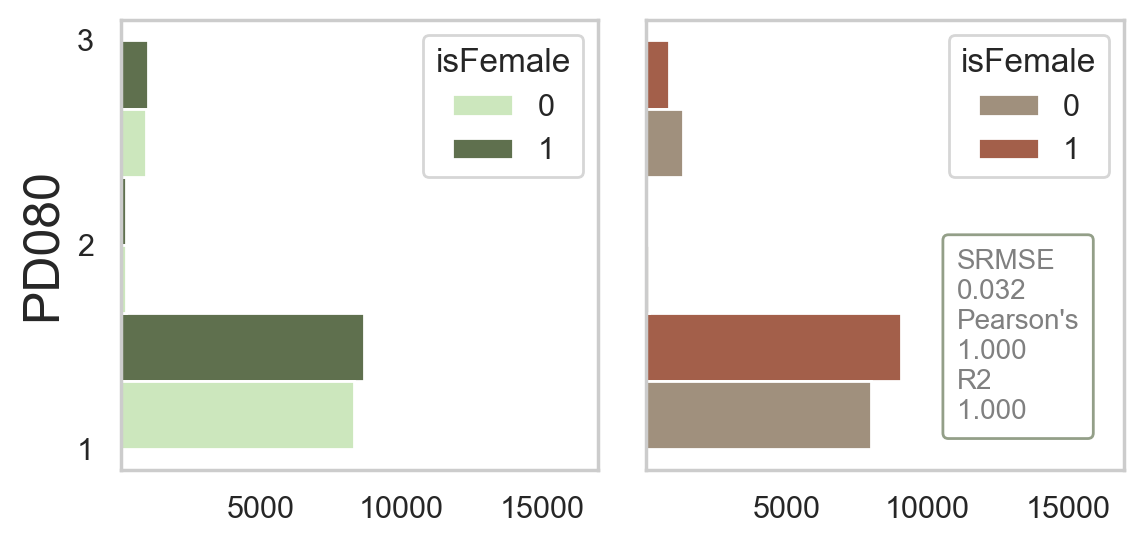

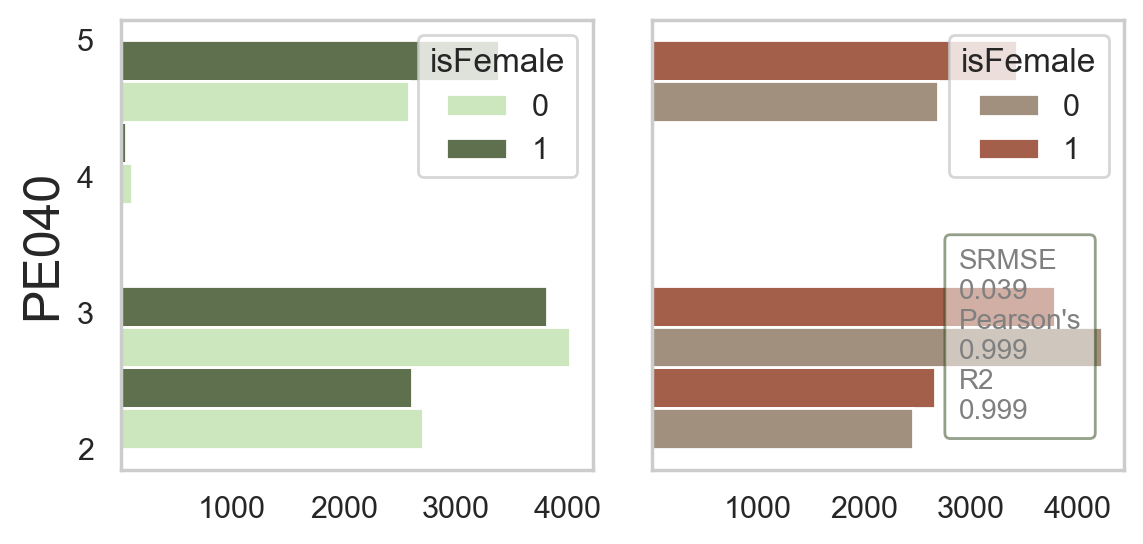

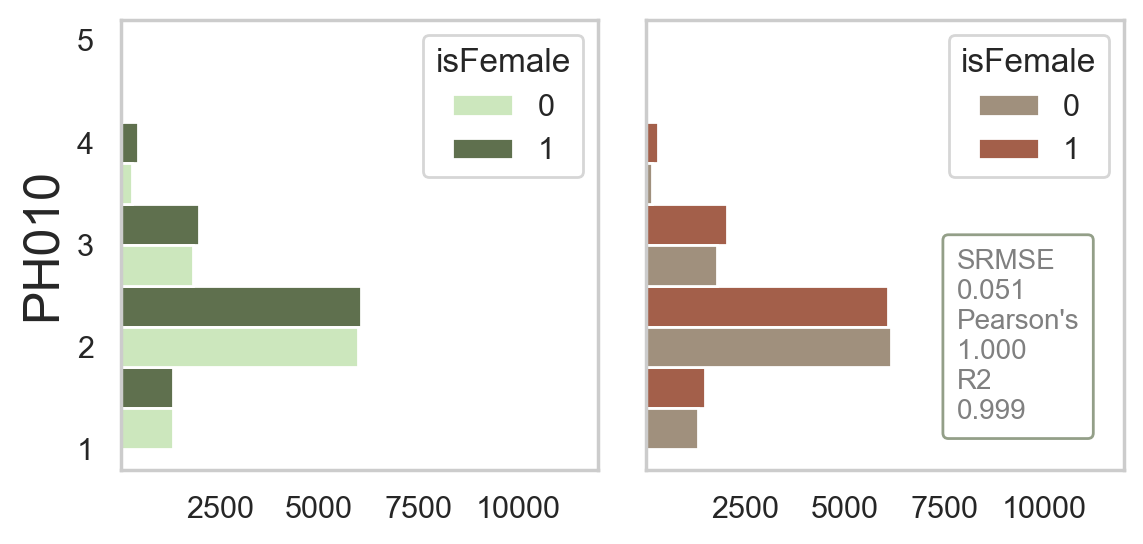

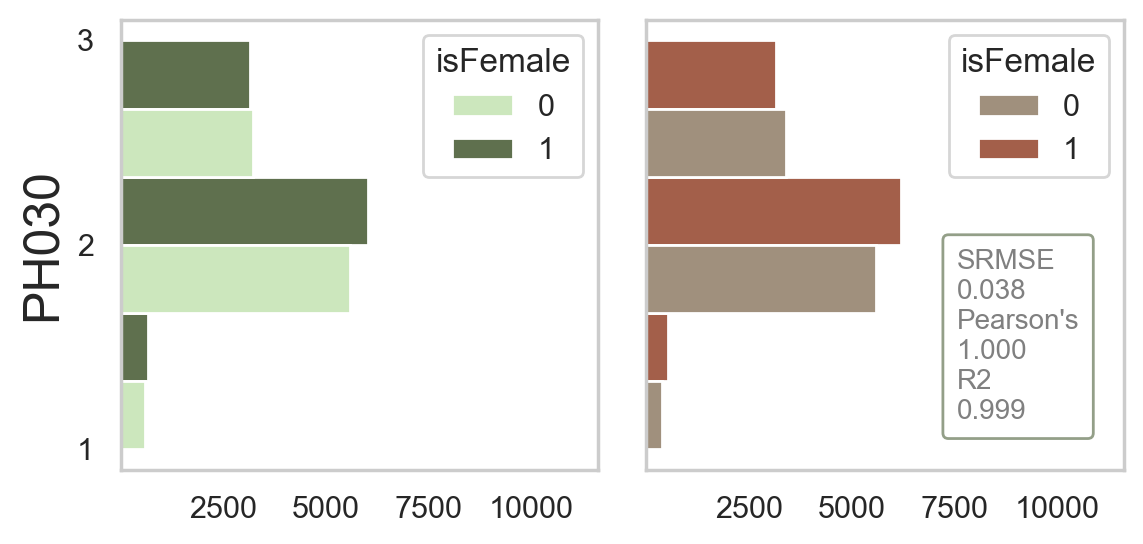

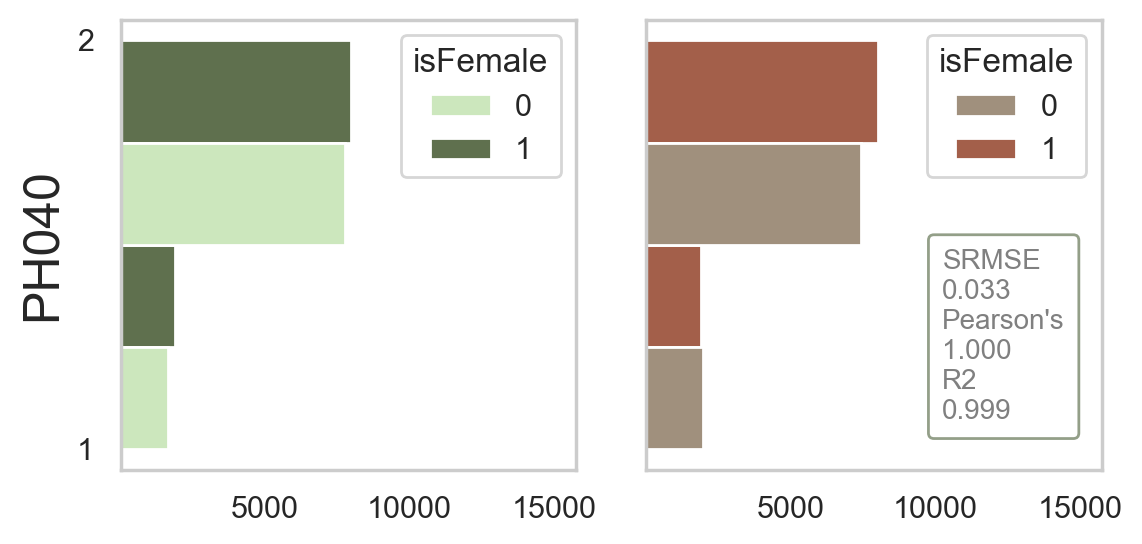

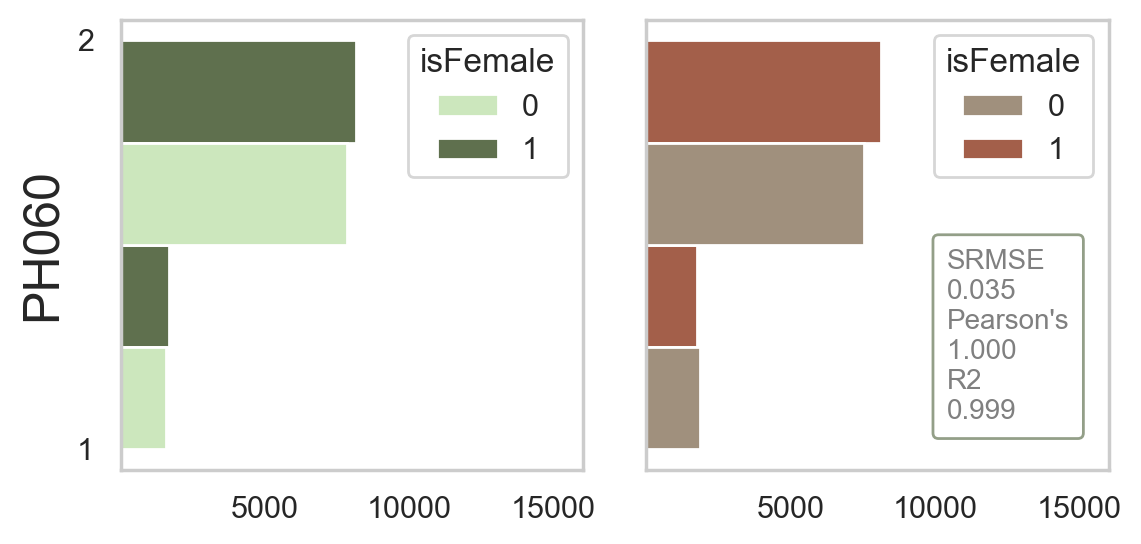

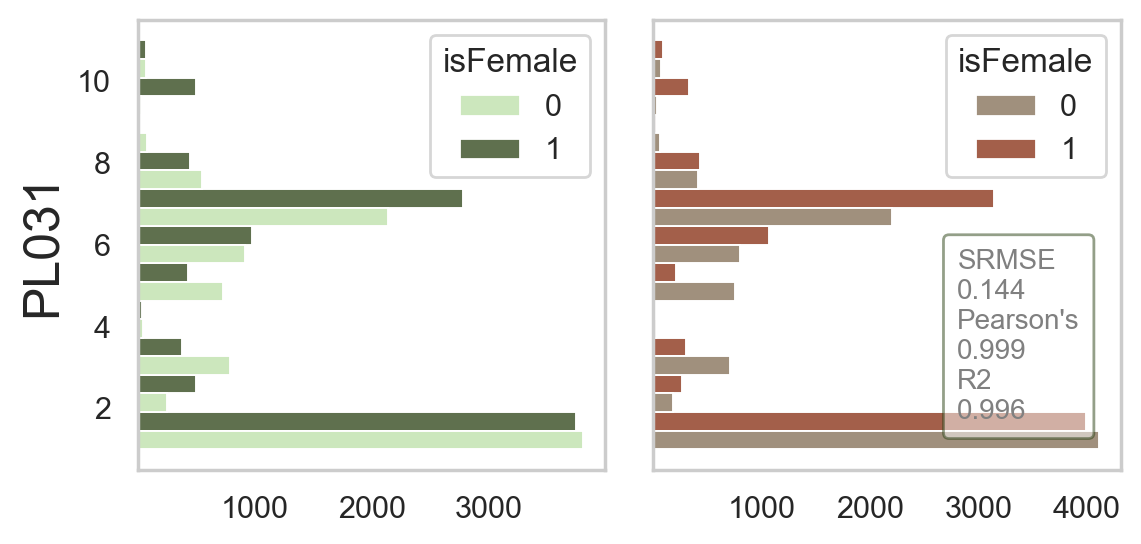

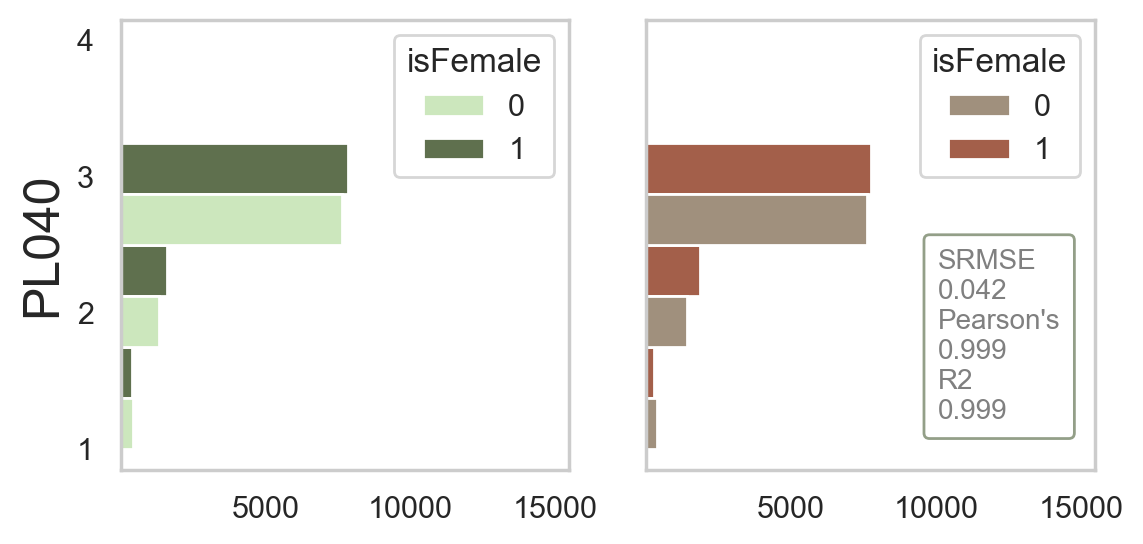

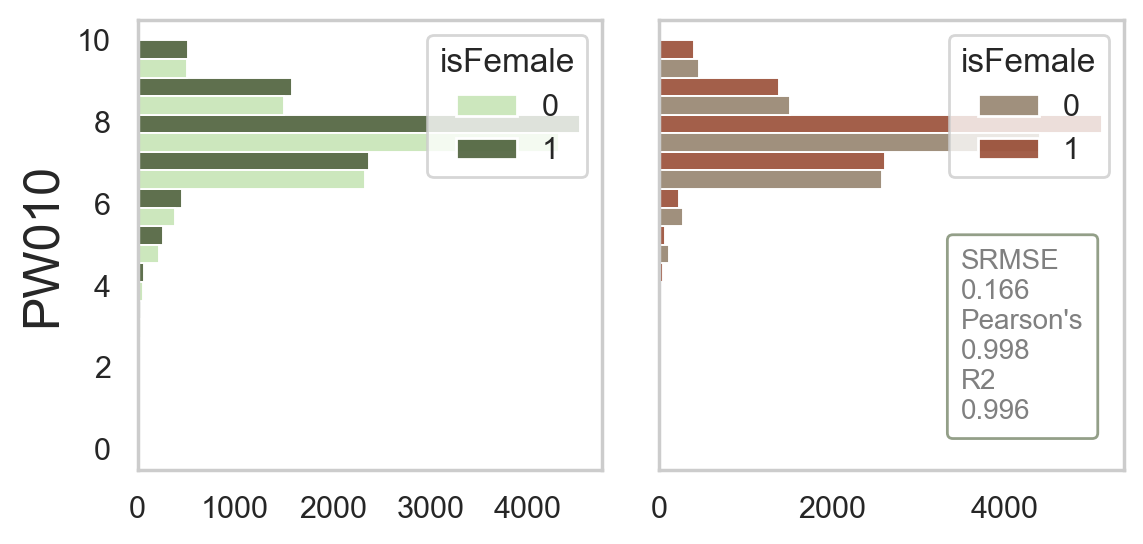

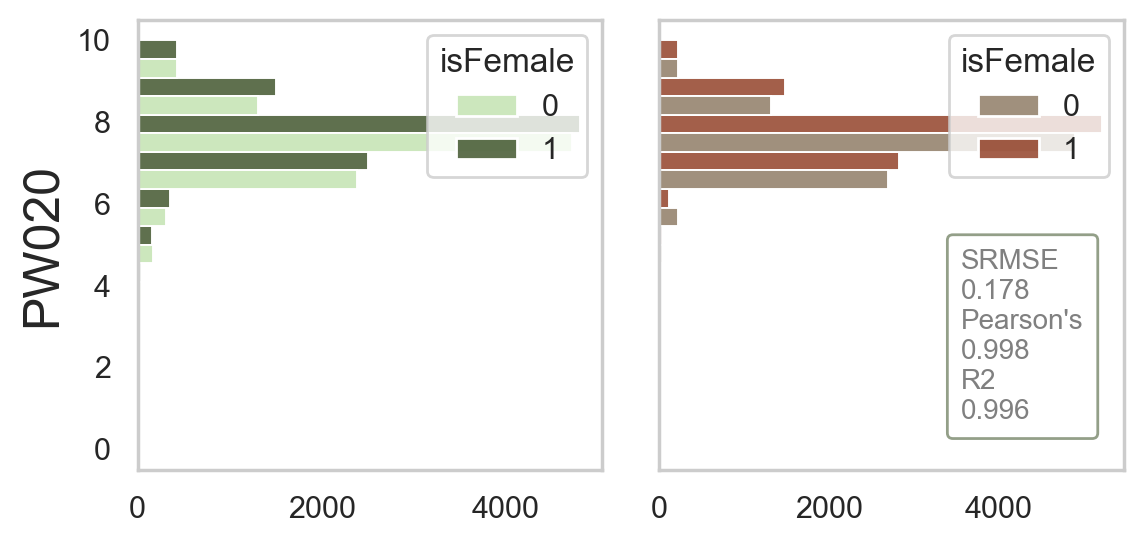

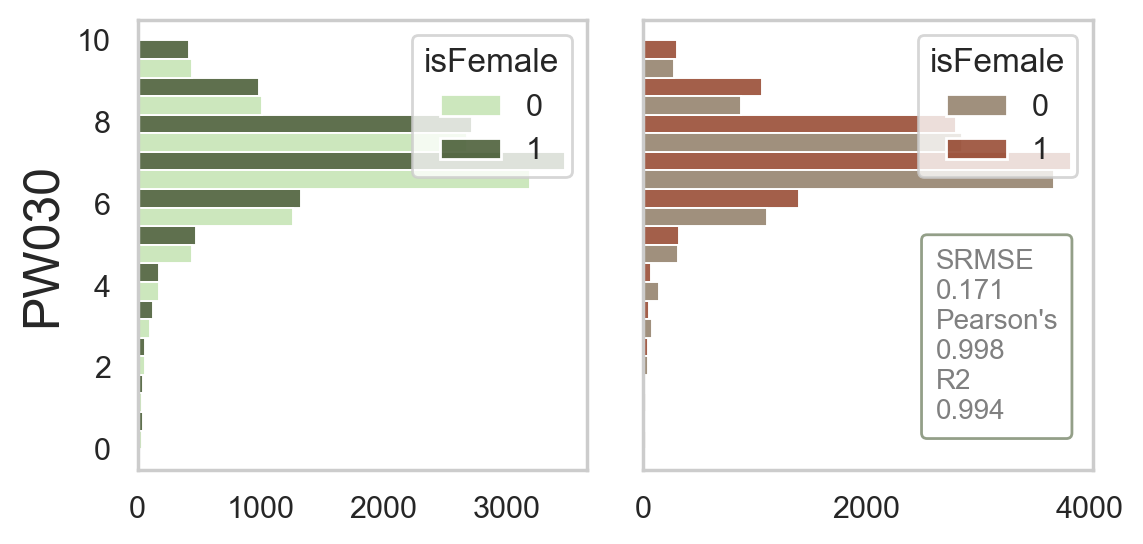

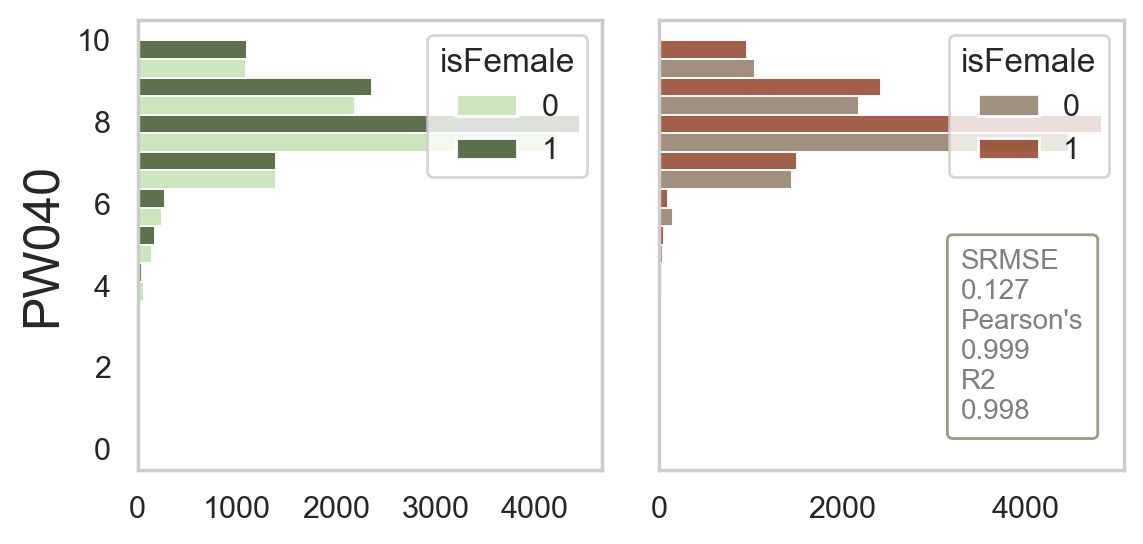

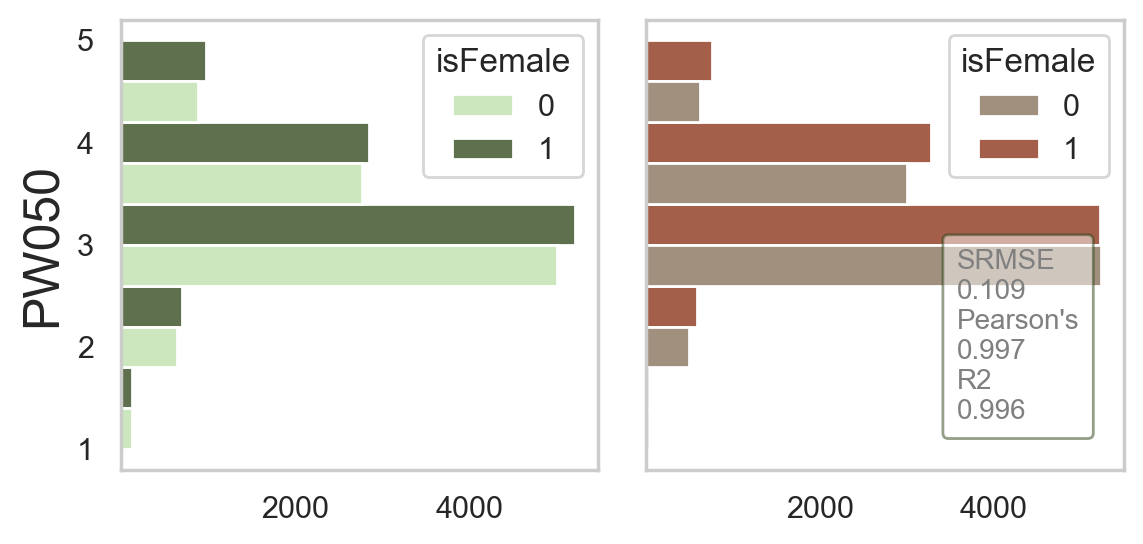

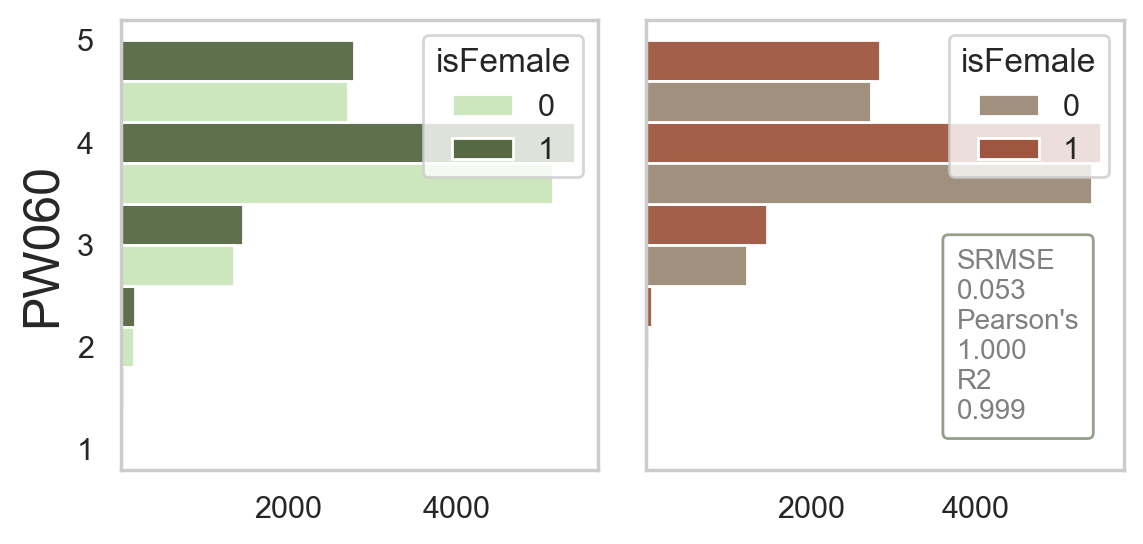

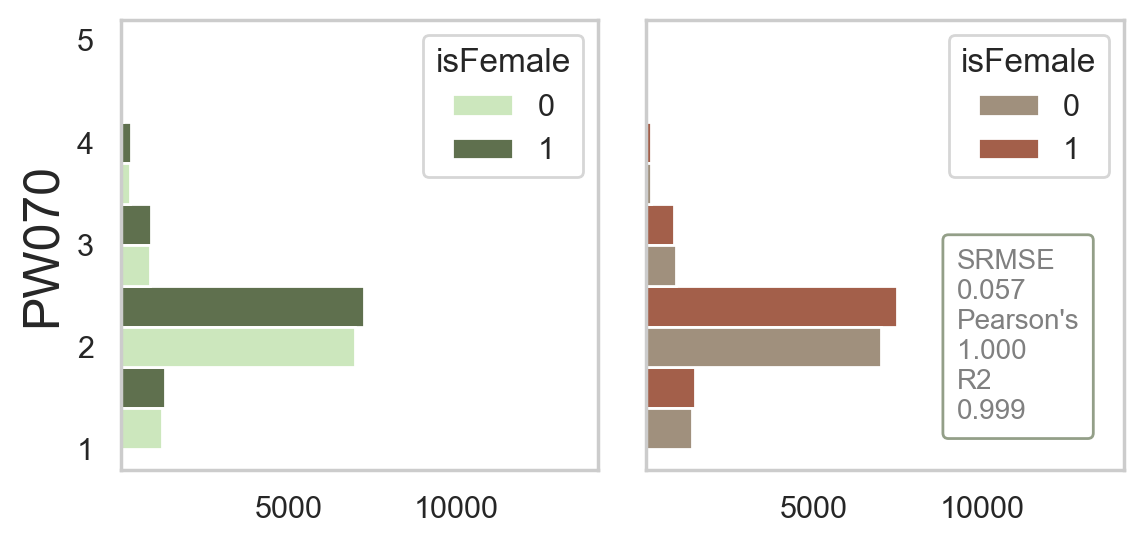

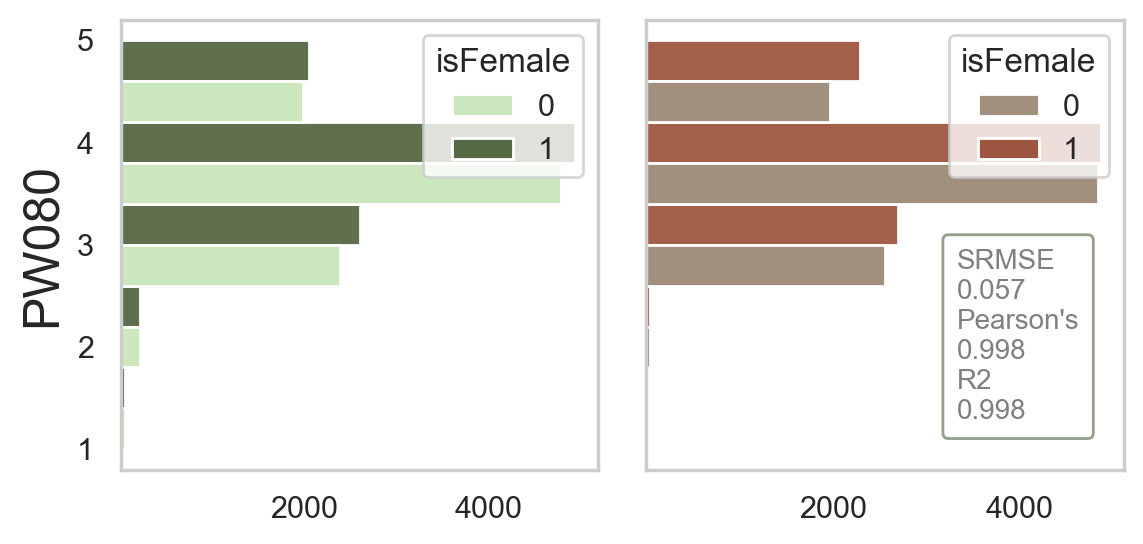

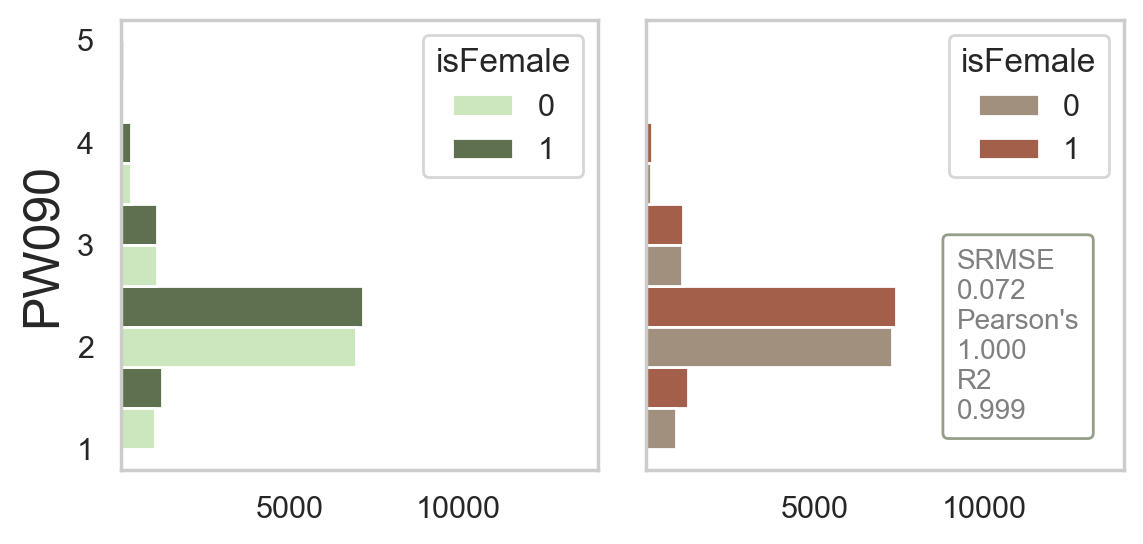

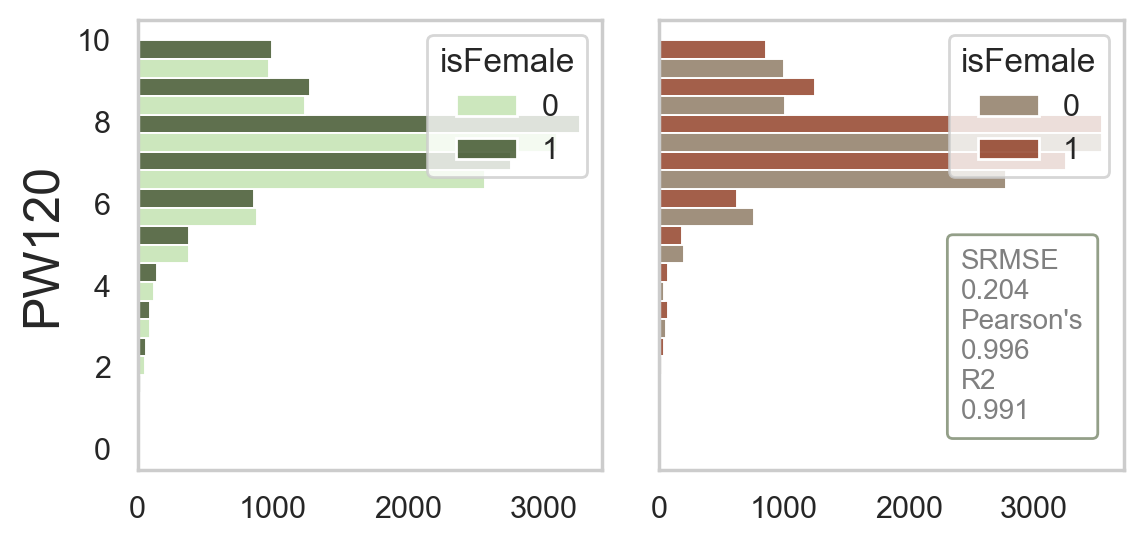

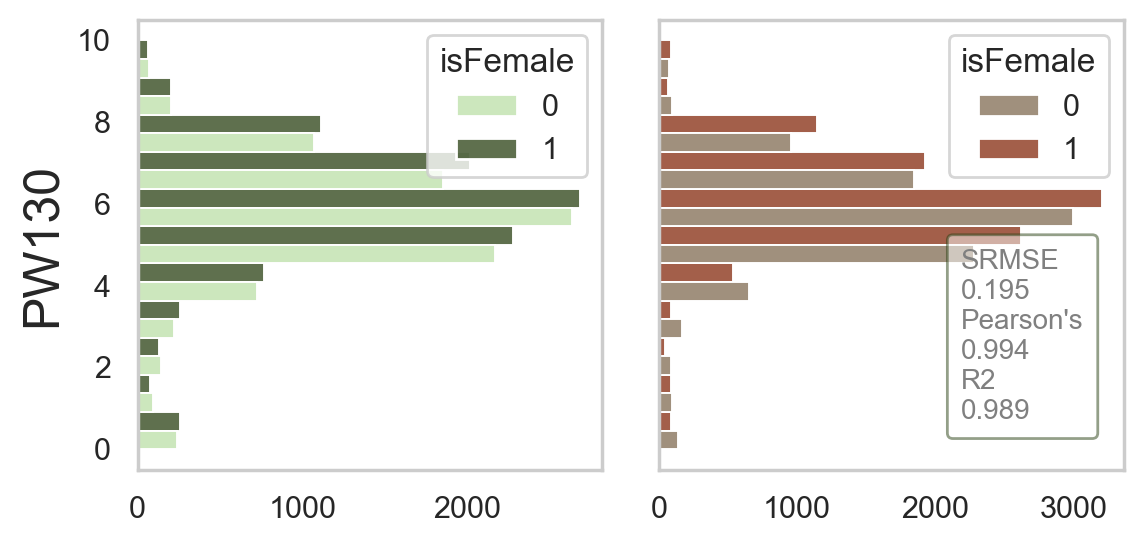

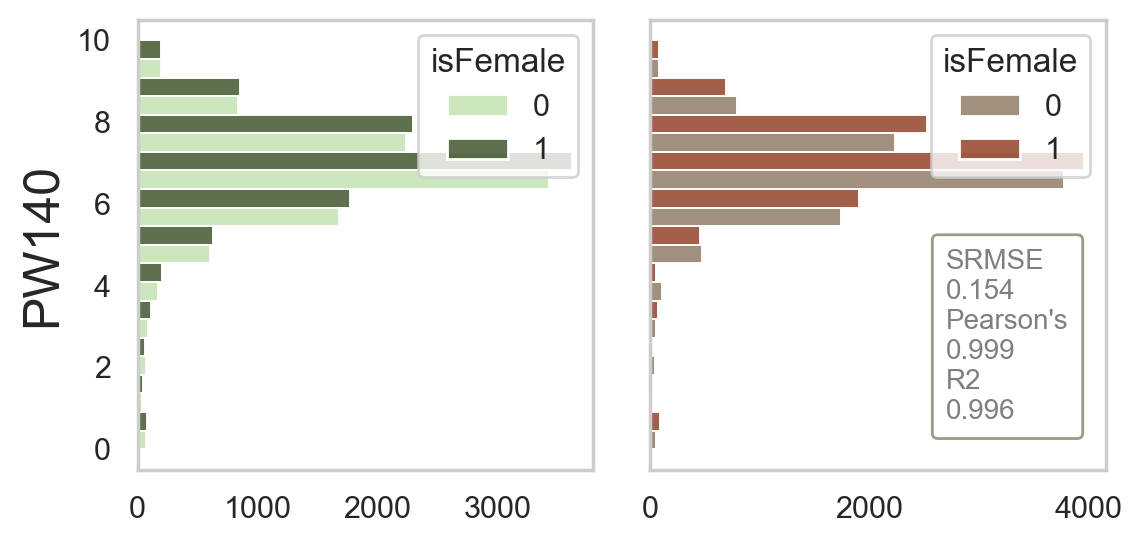

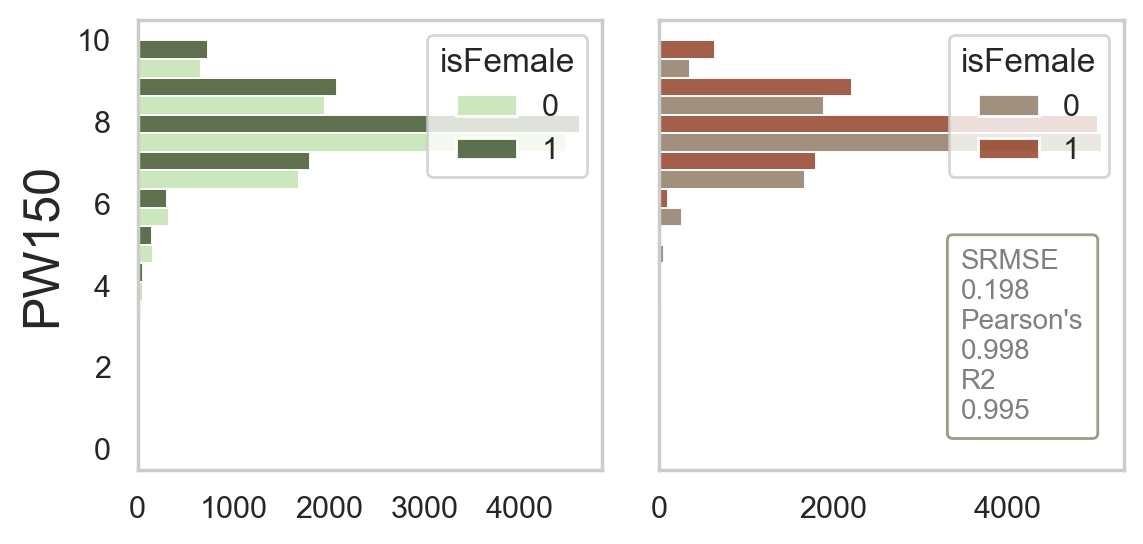

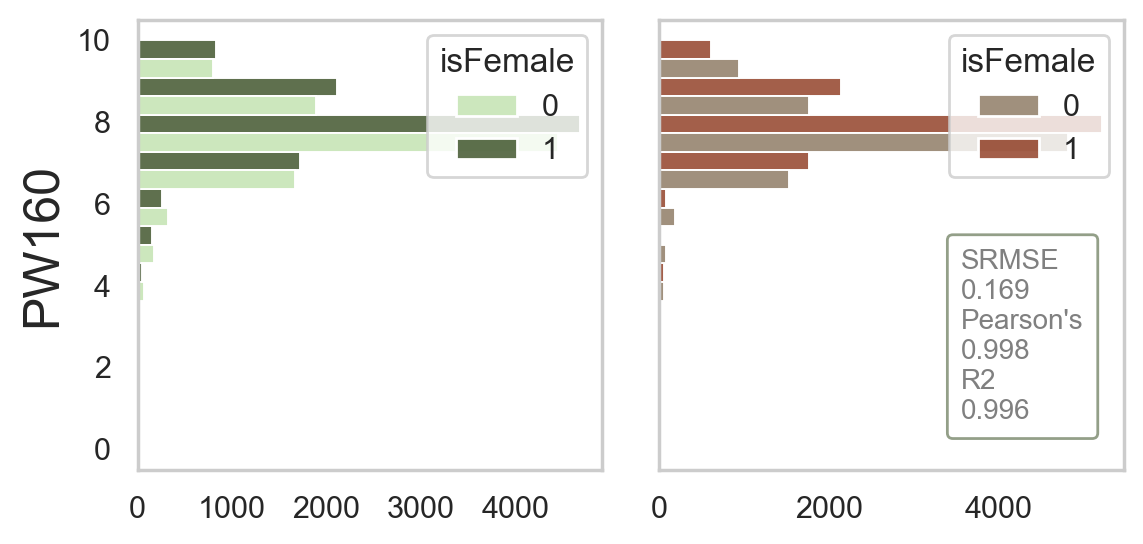

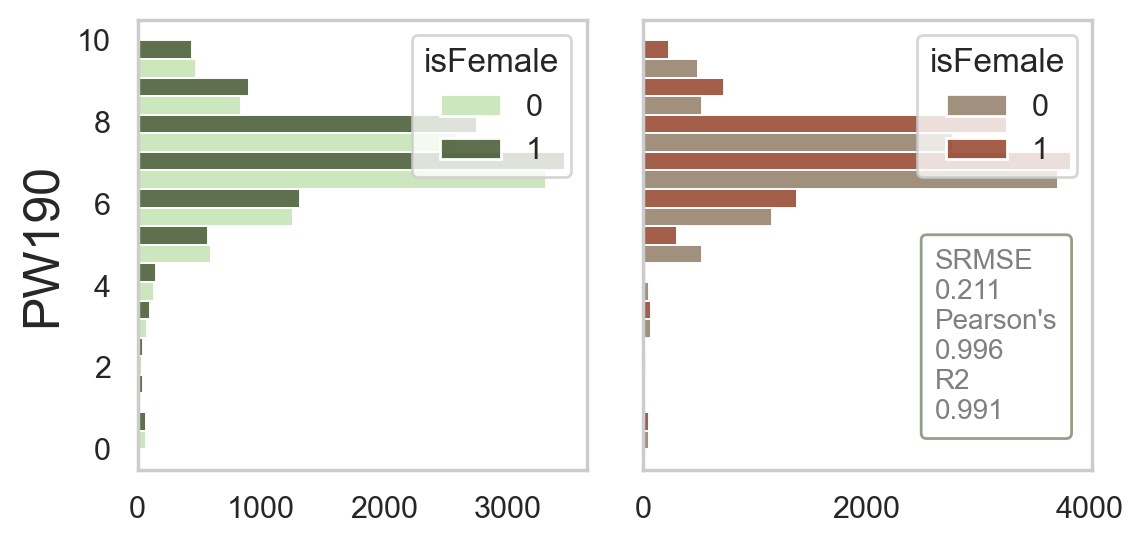

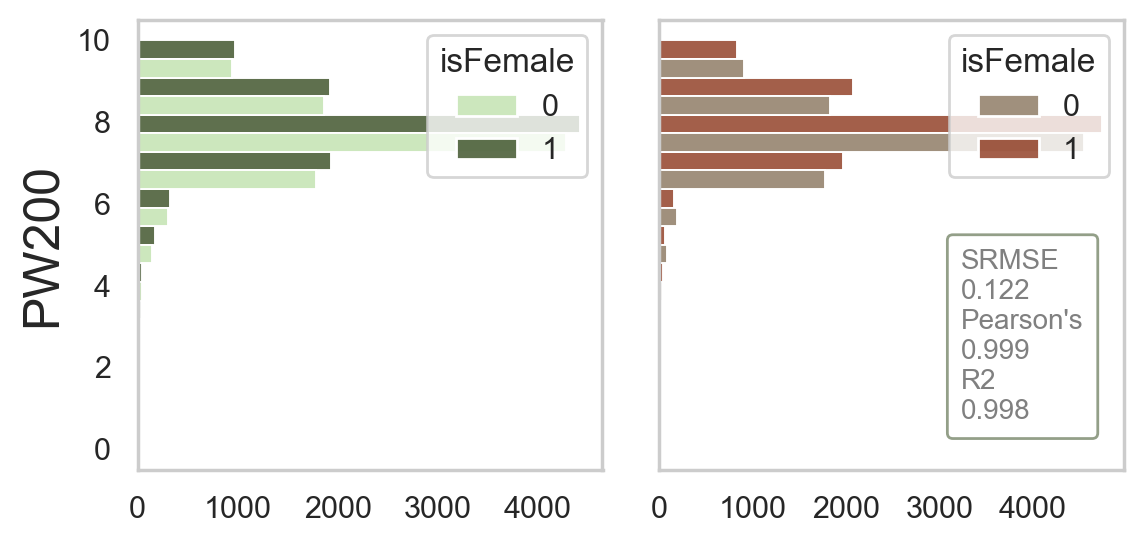

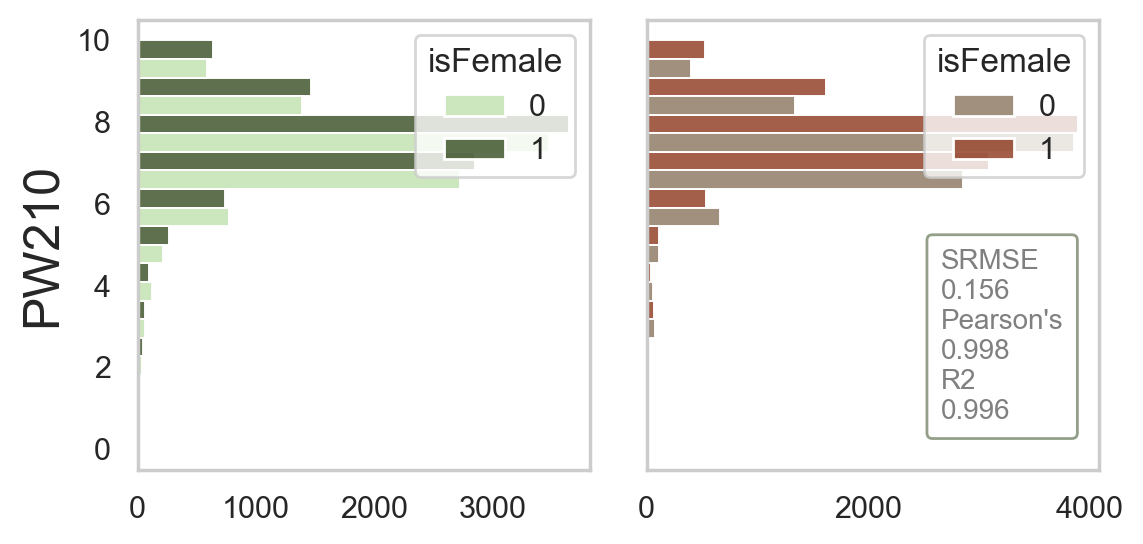

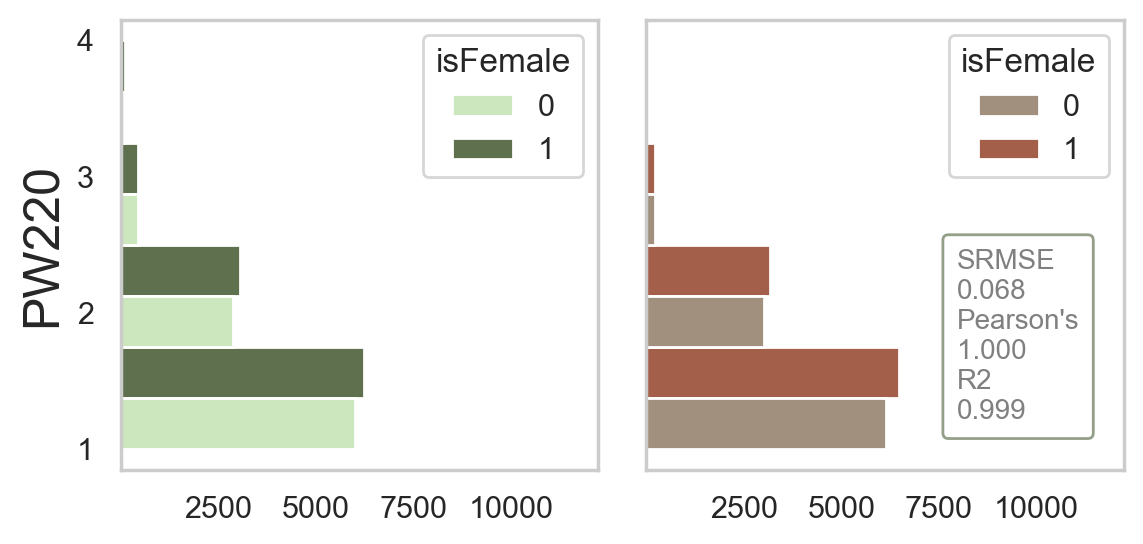

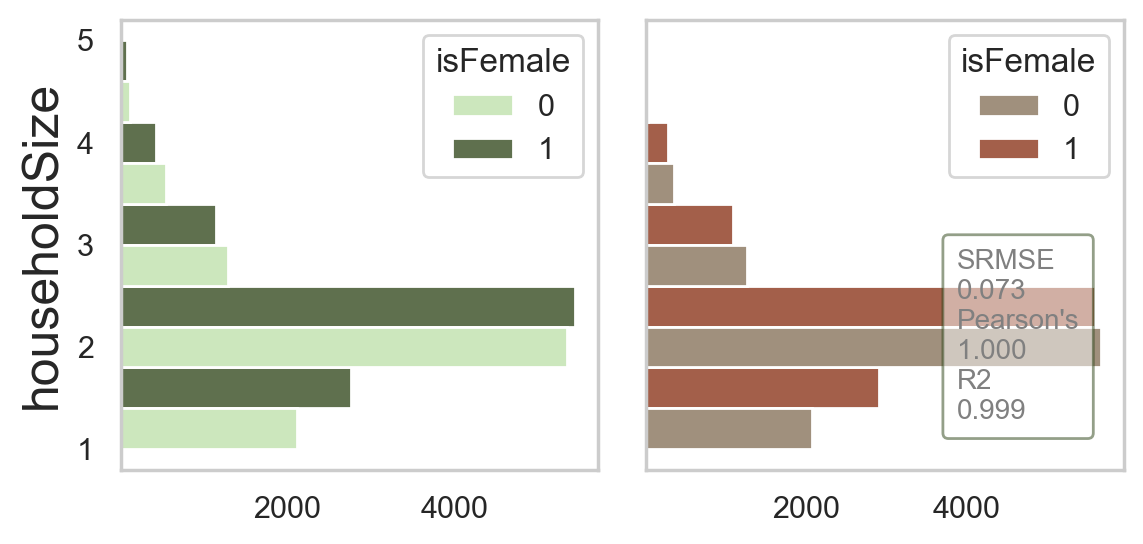

In [36]:
for col in df_o_cat.columns:
    if df_o_cat[col].value_counts().max() > 11000:
        scale_max=df_o_cat[col].value_counts().max()
    else:
        scale_max=None
    if (data.min_values[col] < 1):
        n_bins = int(data.max_bins[col] + 1)
        scale_min = 0
    else:
        scale_min = 1
        n_bins = int(data.max_bins[col])
    draw.plot_two(df_original=df_o_cat, 
                  df_synthetic=df_s_cat,
                  title=col,
                  hue_value="isFemale",
                  n_bins=n_bins,
                  model_type=model_type,
                  model=model,
                  model_name=model_name,
                  scale_max=scale_max,
                  scale_min=scale_min,
                  save=save_figure
                  )